# **ML Models comparative analysis on Obesity - CVD risk data**

## 1. Briefing

|            |          |                     |
|------------|----------|---------------------|
| Subject    |          | Machine Learning    |
| Supervisor |          | Prof. Aswin Kannan  |
|            |          |                     |
| Team Name  |          | MT2025724_MT2025732 |
| Member 1   | Name:    | Shreya Gupta        |
|            | Roll No: | MT2025724           |
| Member 2   | Name:    | Anirudh Sharma      |
|            | Roll No: | MT2025732           |
|            |          |                     |

**Keywords:** Machine Learning, Comparative Study, Grid Search

## 2. Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

| Metrics of the Report                              | Ohh     |
|----------------------------------------------------|---------|
| Total Dataset Size                                 | 15533   |
| Total Features                                     | 16      |
| Total Target Classes                               | 7       |
| Total Missing Values Found                         | 0       |
| Total Outliers Found                               | 5045    |
| Total Duplicated Found                             | 0       |
| Total Data Transformations Explored (A+B)          | 14      |
| Total Continuous Transformations (Eg: Scaling) (A) | 11      |
| Total Discrete Transformations (Eg: Encodings) (B) | 3       |
| Total Feature Selection Strategies Explored        | 5       |
|                                                    |         |
| Total Types of Models Trained                      | 9       |
| Total Number of Hyperparameters Explored           | >40     |
| Total Size of Hyperparameters Space Explored       | >12000  |
| Total Cross-Validation Folds                       | 5       |
|                                                    |         |
| Best Model                                         | XGBoost |
| Best Model's Performance (Accuracy)                | 91.26%  |
| Best Model's Search Time                           | 15 min  |
| Best Model's Training Time                         | 1.5 sec |
| Best Model's Prediction Time                       | 32 msec |
| Best Model's Memory Size                           | 2.41 MB |
| Best Model's Recall                                | 89.82%  |
| Best Model's Precision                             | 89.94%  |
| Best Model's F1 Score                              | 0.8987  |

## 3. Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide — e.g., timing, memory profiling, calibration, fairness tests)


## System Imports

In [227]:
!pip install chime joblib pandas numpy scipy scikit-learn xgboost lightgbm matplotlib seaborn tqdm ipython imbalanced-learn optuna

In [250]:
import chime
import random, time, json
import functools, itertools
import warnings, joblib, inspect

import pandas as pd, numpy as np, scipy as sp
import sklearn as skl, xgboost as xgb, lightgbm as lgb
from imblearn.over_sampling import SMOTENC
import optuna

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
import IPython.display as d

## Helper Functions

### Notification System Setup

In [3]:
# Set notification sound
chime.theme("material")
chime.info()

### Functional Setup

In [4]:
# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)


def flatten(obj):
    if hasattr(obj, '__iter__') and not isinstance(obj, str):
        if hasattr(obj[0], '__iter__') and not isinstance(obj[0], str):
            return list(itertools.chain.from_iterable(obj))
        return obj
    return [obj]

### PyPlot Setup

In [5]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
sml_fig_sq = (4, 4)
wid_fig = (8, 3)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(suptitle: str = None, constrained=False):
    suptitle = suptitle.replace(':', '_').replace('/', '_') if suptitle is not None else None
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.savefig(f'report/figures/plot_{suptitle}.png', dpi=300)
    compose(plt.suptitle, suptitle, font_suptitle)
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.show()


def conclude_csv(ds: pd.DataFrame, name=None, index=False, transpose=False):
    if name is None:
        if isinstance(ds, pd.Series):
            name = ds.name
        else:
            raise NameError()
    ds = ds.copy()
    if transpose: ds = ds.transpose()
    ds = ds.round(2)
    ds.to_csv(f'report/tables/data_{name}.csv', index=index, encoding="utf-8")


chime.info()

### Randomizer Setup

In [6]:
default_seed = 42
current_seed = default_seed


def reset_seed(seed=default_seed):
    global current_seed
    current_seed = seed
    random.seed(seed)
    np.random.seed(seed)


chime.info()

### Presentor Setup

In [7]:
displayMD = lambda x: display(d.Markdown(x))
kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())
header = lambda n, field: "%s %s" % ("#" * n, field)
quote = lambda field: "\n\n> %s" % field.replace("\n", "\n> ")
list_out = lambda title, list: header(4, "%s\n\n* %s" % (title, "\n* ".join(list)))

### Transformation Helpers

In [8]:
def pop_drop_column(data, none=None):
    return (None,), None


def pop_log_transform(data, base=np.e):
    return (base,), np.log(data) / np.log(base)


def pop_root_transform(data, exp=0.5):
    return (exp,), np.power(data, exp)


def pop_box_cox_transform(data, lam=None):
    if lam is None:
        data, lam = sp.stats.boxcox(data)
    else:
        data = sp.stats.boxcox(data, lmbda=lam)
    return (lam,), data


def pop_one_hot_encode(data, uniques=None, name=None):
    if uniques is not None:
        encoding = np.eye(len(uniques))[np.searchsorted(uniques, data)]
    elif isinstance(data, pd.Series):
        uniques = np.unique(data)
        encoding = pd.get_dummies(data, data.name)
    else:
        uniques, indices = np.unique(data, return_inverse=True)
        encoding = np.eye(len(uniques))[indices]

    return (uniques, name), encoding


def pop_soft_ohe(data, split_points):
    produce = []
    produce.append((data < split_points[1]))
    for s, e in zip(split_points[0:-2], split_points[2:]):
        produce.append(data * (data > s) * (data < e))
    produce.append(data * (data > split_points[-2]))
    return (split_points,), produce


def pop_binarize(data, positive=None):
    assert len(np.unique_counts(data)) == 2

    if positive is not None:
        encoding = (data == positive)
    elif isinstance(data, pd.Series):
        positive = np.unique(data)[0]
        encoding = (data == positive)
        encoding.name = "is_%s_%s" % (data.name, positive)
    else:
        positive = np.unique(data)[0]
        encoding = (data == positive)

    return (positive,), encoding


def pop_standardize(data, mean=None, std=None):
    if mean is None:
        mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    return (mean, std), (data - mean) / std


def pop_minmax(data, min=None, max=None):
    if min is None:
        min, max = np.min(data, axis=0), np.max(data, axis=0)
    return (min, max), (data - min) / (max - min)


def pop_ordinal_encode(data, mapping=None):
    if mapping is None:
        uniques = np.unique(data)
        mapping = {cat: idx for idx, cat in enumerate(uniques)}

    encoding = np.array([mapping[row] for row in data])
    return (mapping,), encoding


def de_ordinate(ordinals, mapping):
    mapping = {v: k for k, v in mapping.items()}
    return np.array([mapping[row] for row in ordinals])


def pop_round(data, decimals=0):
    return (decimals,), np.round(data, decimals=(decimals or 0))


def pop_derived_features(data: pd.DataFrame, none=None):
    # data = data.copy()
    data["BMI"] = data["Weight"] / (data["Height"] ** 2)
    data["Water_Intake_per_Meal"] = data["CH2O"] / (data["NCP"] + 1e-6)
    data["Activity_to_Tech_Ratio"] = data["FAF"] / (data["TUE"] + 0.1)
    data["Healthy_Lifestyle_Score"] = (data["FCVC"] * 0.3 + data["FAF"] * 0.3
                                       + data["CH2O"] * 0.4 - data["FAVC"].map({"yes": 1, "no": 0}))
    data["Has_FamilyRisk_and_FAVC"] = np.where(
        (data["FHWO"] == "yes") & (data["FAVC"] == "yes"), 1, 0)
    data["Calorie_Monitoring_Interaction"] = (data["SCC"].map({"yes": 1, "no": 0})
                                              * data["FAVC"].map({"yes": 1, "no": 0}))
    return (none,), None


def pop_mask_away(data: pd.DataFrame, mask):
    data = data.copy()
    return (mask,), data[mask]


def pop_epsilon(data: pd.DataFrame, e=1e-6):
    return (e,), data + e


def compose_pop(*pop_operations):
    pop_operations = flatten(pop_operations)

    def pop_composed(data, arguments=None):
        if arguments is None:
            arguments = []
            for pop_operation in pop_operations:
                args, data = pop_operation(data)
                # if data is None: continue
                arguments.append([pop_operation.__name__, args])
            return (arguments,), data
        else:
            for args, pop_operation in zip(arguments, pop_operations):
                _, data = pop_operation(data, *(args[1]))
            return (arguments,), data

    return pop_composed


# Embed arguments
def prepare_pop(pop_operation, *args):
    def pop_prepared(data, none=None):
        return (args,), pop_operation(data, *args)[1]

    return pop_prepared


def iterate_pipeline_variants(pipeline):
    compulsory, permutable = pipeline[0], pipeline[1]
    if len(permutable) == 0:
        yield compulsory
    for perm in permutable:
        yield compulsory + perm


def apply_pop(pop, ds, cols, args=()):
    if cols is None:
        return pop(ds, *args)
    if isinstance(cols, str) and cols not in ds.columns:
        return (None,), None
    return pop(ds[cols], *args)


def integrate_pop(ds: pd.DataFrame, col, data):
    if data is None:
        pass  # Possibly an inplace operation
    elif isinstance(data, np.ndarray) and len(data.shape) <= 1:
        ds[col] = data
    elif isinstance(data, pd.Series):
        ds[data.name] = data
    elif isinstance(data, np.ndarray) and len(data.shape) == 2:
        for idx in range(data.shape[1]):
            ds["%s_%02d" % (col, idx)] = data[:, idx]
    elif isinstance(data, pd.DataFrame):
        for new_col in data.columns:
            ds[new_col] = data[new_col]
    elif isinstance(data, list):
        for idx in range(len(data)):
            ds["%s_%02d" % (col, idx)] = data[idx]
    else:
        raise ValueError(type(data))


def apply_pipeline(pipeline, ds, arguments=None, to_numpy=True):
    ds = ds.copy()
    if arguments is None:
        arguments = []
        for pop, cols, drop in pipeline:
            if not isinstance(cols, list): cols = [cols]
            for col in cols:
                args, data = apply_pop(pop, ds, col)
                if drop and col in ds.columns: ds.drop(columns=col, inplace=True)
                arguments.append(args)
                integrate_pop(ds, col, data=data)
    else:
        argIdx = 0
        for pop, cols, drop in pipeline:
            if not isinstance(cols, list): cols = [cols]
            for col in cols:
                # print(pop.__name__, col)
                args, data = apply_pop(pop, ds, col, arguments[argIdx])
                if drop and col in ds.columns: ds.drop(columns=col, inplace=True)
                argIdx += 1
                integrate_pop(ds, col, data=data)

    if to_numpy: ds = ds.to_numpy()

    return arguments, ds


def select_pipeline_variation(pipeline, index):
    return pipeline[0] + pipeline[1][index]

### Model Helpers

In [68]:
def save_model(model, path):
    joblib.dump(model, path)


def load_model(path):
    return joblib.load(path)


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = skl.metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=sml_fig_sq)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    conclude_plot(title, True)


def displayAUCScore(test_x, test_y, model):
    try:
        auc_score = None
        if len(np.unique(test_y)) == 2:
            test_prob_y = model.predict_proba(test_x)[:, 1]
            auc_score = skl.metrics.roc_auc_score(test_y, test_prob_y)
        elif len(np.unique(test_y)) > 2 and hasattr(model, "predict_proba"):
            test_prob_y = model.predict_proba(test_x)
            auc_score = skl.metrics.roc_auc_score(test_y, test_prob_y, multi_class='ovr', average='macro')

        if auc_score is not None:
            displayMD(header(4, kv('Test Multiclass ROC AUC Score (OVR)', f"{auc_score:.4f}")))
    except Exception as e:
        displayMD(f"**Note:** AUC score failed to calculate: {e}")


def evaluate_model(model, train_x, train_y, test_x, test_y, silent=False, name=None):
    if name is None:
        name = model.__class__.__name__

    reset_seed()
    model.fit(train_x, train_y)

    train_pred_y = model.predict(train_x)
    test_pred_y = model.predict(test_x)

    if not silent: displayMD(header(3, f"Evaluation: {name}"))

    train_accuracy = skl.metrics.accuracy_score(train_y, train_pred_y)
    test_accuracy = skl.metrics.accuracy_score(test_y, test_pred_y)

    if not silent:
        displayMD(header(4, kv('Train Accuracy', f"{train_accuracy:.4f}")))
        displayMD(header(4, kv('Val Accuracy', f"{test_accuracy:.4f}")))
        displayAUCScore(test_x, test_y, model)
        plot_confusion_matrix(test_y, test_pred_y, target_labels, title=f"Confusion Matrix: {name}")

    return train_accuracy, test_accuracy


def save_submission(key, model, data_test_ids, data_test, data_y_codex):
    key = "".join([c for c in key if c not in '<>:"/\\|?*'])
    ds_res = pd.DataFrame()
    ds_res['id'] = data_test_ids
    ds_res['WeightCategory'] = de_ordinate(model.predict(data_test), data_y_codex)
    ds_res.to_csv(f'submissions/{key}.csv', index=False)

## Data Loading and Description

In [10]:
# Load data from train and test CSVs - train data is to be used for model training an dtesting, test is to be used for generatign the final predictions

ds_source = pd.read_csv("train.csv")
ds_test = pd.read_csv("test.csv")

ds_source.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)
ds_test.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)

chime.info()

In [11]:
# Analyze basic data shape - input features and target column

n_samples_all, n_columns = ds_source.shape
n_features_raw = n_columns - 2  # id and targets

target_labels = ds_source['WeightCategory'].unique()
n_targets = len(target_labels)

displayMD(header(4, kv('Number of total samples', n_samples_all)))
displayMD(header(4, kv('Number of total columns', n_columns)))
displayMD(header(4, kv('Number of features', n_features_raw)))
displayMD(header(4, kv('Number of classes in target feature', n_targets)))
conclude_csv(pd.DataFrame([['Total Samples', n_samples_all], ['Total Columns', n_columns], ['Features', n_features_raw],
                           ['Targets', n_targets], ], columns=['Stat', 'Meta']), 'dataset_statistics')

#### **Number of total samples:** `15533`

#### **Number of total columns:** `18`

#### **Number of features:** `16`

#### **Number of classes in target feature:** `7`

In [12]:
# Dictionary to replace column names with their full forms for better interpretability

column_full_names = {
    'id': 'Entity Identifier', 'Gender': 'Gender', 'Age': 'Age', 'Height': 'Height', 'Weight': 'Weight',
    'FHWO': 'Family History With Overweight', 'FAVC': 'High Caloric Food Consumption Freq.',
    'FCVC': 'Vegetables Consumption Freq.', 'NCP': 'Main Meals Count', 'CAEC': 'Consumption of Food Between Meals',
    'SMOKE': 'Smoke', 'CH2O': 'Consumption of Water Daily', 'CALC': 'Consumption of alcohol',
    'SCC': 'Calories Consumption Monitoring', 'FAF': 'Physical Activity Freq.', 'TUE': 'Time using Technology Devices',
    'MTRANS': 'Modes of Transportation Used', 'WeightCategory': 'Weight Category', }

In [13]:
info = pd.io.formats.info.DataFrameInfo(
    data=ds_source,
    memory_usage=None,
)
ds_info = pd.DataFrame(zip(info.ids, info.ids.map(column_full_names), info.non_null_counts, info.dtypes),
                       columns=['Column Name', 'Description', 'Non-Null Count', 'Data Type'])

In [14]:
displayMD(header(3, kv('Memory Usage', info.memory_usage_string)))
conclude_csv(ds_info, "dataset_info")
display(ds_info)

### **Memory Usage:** `2.1+ MB`

,Column Name,Description,Non-Null Count,Data Type
0,id,Entity Identifier,15533,int64
1,Gender,Gender,15533,object
2,Age,Age,15533,float64
3,Height,Height,15533,float64
4,Weight,Weight,15533,float64
5,FHWO,Family History With Overweight,15533,object
6,FAVC,High Caloric Food Consumption Freq.,15533,object
7,FCVC,Vegetables Consumption Freq.,15533,float64
8,NCP,Main Meals Count,15533,float64
9,CAEC,Consumption of Food Between Meals,15533,object


In [15]:
# Display column datatype-wise

gb_info_by_dtype = ds_info.groupby('Data Type')['Column Name'].apply(list)
ds_dtype = pd.DataFrame({
    t: items + ['-'] * (gb_info_by_dtype.map(len).max() - len(items))
    for t, items in gb_info_by_dtype.items()
})
conclude_csv(ds_dtype, "dataset_dtypes")
display(ds_dtype)

,int64,float64,object
0,id,Age,Gender
1,-,Height,FHWO
2,-,Weight,FAVC
3,-,FCVC,CAEC
4,-,NCP,SMOKE
5,-,CH2O,SCC
6,-,FAF,CALC
7,-,TUE,MTRANS
8,-,-,WeightCategory


In [16]:
# Display first five rows of the data

conclude_csv(ds_source.head(5), "dataset_head")
display(ds_source.head(5))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [17]:
# Display statistical data analysis for both numerical and categorical columns

ds_describe = ds_source.describe(include='all')
ds_describe.index = ['count', 'unique', 'top', 'freq', 'mean', 'std', 'min', '25', '50', '75', 'max']
conclude_csv(ds_describe
             .map(lambda y: np.round(y, 2) if isinstance(y, float) else y)
             .map(lambda y: (y[:5] + '.') if isinstance(y, str) else y)
             .rename(columns={'WeightCategory': 'Targets'})
             .fillna("_"), "dataset_describe", index=True, transpose=True)
display(ds_describe)

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
count,15533.000000,15533,15533.000000,15533.000000,15533.000000,15533,15533,15533.000000,15533.000000,15533,15533,15533.000000,15533,15533.000000,15533.000000,15533,15533,15533
unique,NaN,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,NaN,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,NaN,7783,NaN,NaN,NaN,12696,14184,NaN,NaN,13126,15356,NaN,15019,NaN,NaN,11285,12470,2983
mean,7766.000000,NaN,23.816308,1.699918,87.785225,NaN,NaN,2.442917,2.760425,NaN,NaN,2.027626,NaN,0.976968,0.613813,NaN,NaN,NaN
std,4484.135201,NaN,5.663167,0.087670,26.369144,NaN,NaN,0.530895,0.706463,NaN,NaN,0.607733,NaN,0.836841,0.602223,NaN,NaN,NaN
min,0.000000,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25,3883.000000,NaN,20.000000,1.630927,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.796257,NaN,0.007050,0.000000,NaN,NaN,NaN
50,7766.000000,NaN,22.771612,1.700000,84.000000,NaN,NaN,2.342220,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.566353,NaN,NaN,NaN
75,11649.000000,NaN,26.000000,1.762921,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.531456,NaN,1.582675,1.000000,NaN,NaN,NaN


**Inference**

The statistical summary reveals a complete dataset with no missing values across all 18 features (count 15,533). Numerical features, notably Weight (range 39.0 to 165.1 kg), exhibit varying scales and likely skewness, necessitating scaling and potential transformation (e.g., log) to standardize ranges for modeling. Categorical columns show significant class imbalance (e.g., $98.8\%$ 'no' for SMOKE), and the target variable, WeightCategory, is a seven-class classification problem that requires Label Encoding and suggests the need for stratified cross-validation and class weighting during model evaluation to achieve robust performance across all risk categories.

In [18]:
# Separate out the various categories of features

redundant_columns = ['id']
target_columns = ['WeightCategory']

gaussian_features = ['Age', 'Height', 'Weight']
partial_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC']
nary_features = ['CAEC', 'CALC', 'MTRANS']

numerical_features = gaussian_features + partial_features
categorical_features = binary_features + nary_features
all_features = numerical_features + categorical_features

numerical_derived_features = ["BMI", "Water_Intake_per_Meal", "Activity_to_Tech_Ratio", "Healthy_Lifestyle_Score"]
binary_derived_features = ["Has_FamilyRisk_and_FAVC", "Calorie_Monitoring_Interaction"]
derived_features = numerical_derived_features + binary_derived_features

label_encoder = {label: index for index, label in enumerate(target_labels)}
label_decoder = {index: label for index, label in enumerate(target_labels)}

## Exploratory Data Analysis

#### Missing Value Detection

In [19]:
ds_missing = ds_source.isnull().sum().to_frame(name='Missing Count')
conclude_csv(ds_missing, "eda_missing_counts", index=True)
display(ds_missing)

,Missing Count
id,0
Gender,0
Age,0
Height,0
Weight,0
FHWO,0
FAVC,0
FCVC,0
NCP,0
CAEC,0


**Observation**: There is not a single missing value in any of the columns

**Inference**: The dataset is pretty good in this department! We do not have to perform any sorts of missing value handling procedures like removal, imputation or flagging.

#### Outlier Detection

In [20]:
# Find the number of values below or above the IQR

def count_outliers(ds: pd.DataFrame, column: str):
    quan25 = ds[column].quantile(0.25)
    quan75 = ds[column].quantile(0.75)
    iqr = quan75 - quan25
    lower_limit = quan25 - 1.5 * iqr
    upper_limit = quan75 + 1.5 * iqr
    outlier_mask = (ds[column] > upper_limit) | (ds[column] < lower_limit)
    return len(ds[outlier_mask]), outlier_mask


_ds_num = ds_source[numerical_features]
ds_outliers = pd.DataFrame(zip(_ds_num.columns, [count_outliers(_ds_num, col)[0] for col in _ds_num.columns]),
                           columns=['', 'Outliers_Count'])
conclude_csv(ds_outliers, "eda_outlier_counts")
display(ds_outliers)

,,Outliers_Count
0,Age,792
1,Height,4
2,Weight,0
3,FCVC,0
4,NCP,4548
5,CH2O,0
6,FAF,0
7,TUE,0


In [89]:
outliers_mask = (1 - (count_outliers(ds_source, 'Age')[1] + count_outliers(ds_source, 'NCP')[1])).astype(bool)

**Observation**: Age and NCP has a significant number of values outside the IQR

**Inference**: A lot of values outside of the IQR might indicate a possible issue in the data distribution since dropping or imputing such huge percentage of values, isn't recommended.

#### Feature Distribution

In [82]:
ds_duplicates = ds_source.duplicated()
conclude_csv(ds_duplicates, "eda_duplicate_counts", index=True)
display(ds_duplicates)

0        False
1        False
2        False
3        False
4        False
         ...  
15528    False
15529    False
15530    False
15531    False
15532    False
Length: 15533, dtype: bool

**Observation**: There is not a single duplicate value in any of the columns

**Inference**: The dataset is pretty good in this department too! We do not have to perform any sorts of duplicated value handling procedures.

#### Feature Distribution

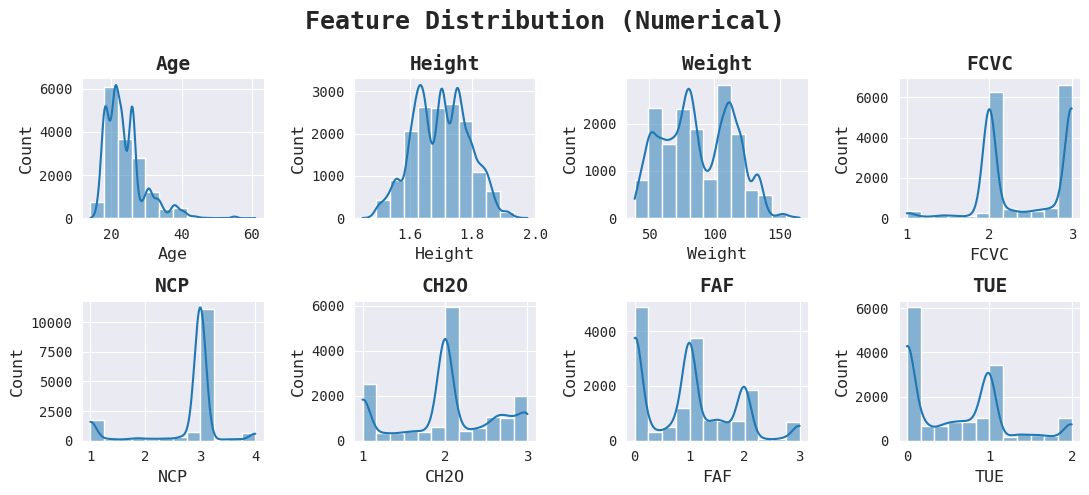

In [22]:
# Feature distribution plots for each of the numerical features

fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), numerical_features):
    sns.histplot(ds_source[col], kde=True, bins=12, ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Numerical)")

**Observation**:
* Age is moderately right-skewed, with the bulk of the data clustered between roughly 18 and 30 years old.
* Height and Weight follow a somewhat traditional, unimodal distribution but show signs of slight multimodality in the case of Weight.
* All features other than Age, Height, and Weight (FCVC, NCP, CH20, FAF, TUE) exhibit clear multimodality, with peaks centered around specific, distinct values.
* FAF (Physical Activity) is heavily right-skewed, showing a significant frequency of low or zero activity.

**Inference**: The dataset contains a mix of standard continuous-like features (Age, Height, Weight) and several features that appear to be categorical or ordinal measures (FCVC, NCP, CH20, TUE) where responses cluster at specific points.

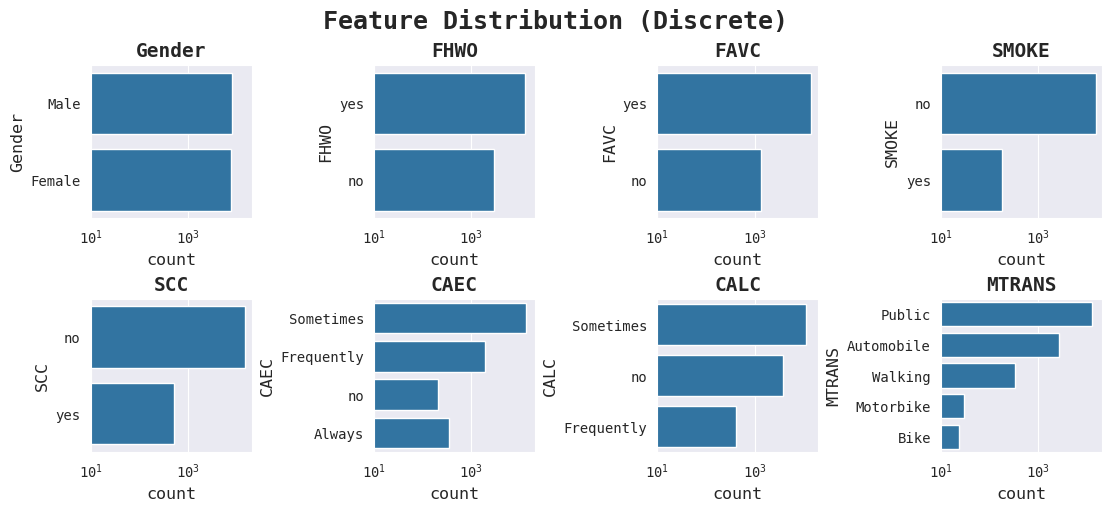

In [23]:
# Feature distribution plots for each of the categorical features

fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), categorical_features):
    sns.countplot(ds_source[col], ax=ax)
    annotate_plot(ax, col), ax.set_xscale('log'), ax.set_xlim(10, 20000)
    if col == 'MTRANS': ax.set_yticks(range(5), ['Public', 'Automobile', 'Walking', 'Motorbike', 'Bike'], **font_ticks)
conclude_plot("Feature Distribution (Discrete)", constrained=True)

**Observation**:
* Gender is very well distributed; the counts for Male and Female are nearly equal.
* Family History With Overweight (FHWO) and High Caloric Food Consumption Freq (FAVC) have a moderate skewedness, with 'yes' counts being significantly higher than 'no'.
* Smoke (SMOKE) and Calories Consumption Monitoring (SCC) show strong skewedness, with 'no' responses dominating 'yes' responses (SCC is more skewed than SMOKE).
* Consumption of Food Between Meals (CAEC), Consumption of alcohol (CALC), and Means of Transportation Used (MTRANS) are highly heterogeneous/multi-category skewed, where counts are spread across multiple categories with one or two dominant levels (e.g., 'Sometimes' for CAEC, 'Public' for MTRANS).

**Inference**:
* The dataset is primarily composed of individuals with a family history of overweight and who frequently consume high-caloric foods. However, they do not typically smoke or monitor their calorie consumption. Furthermore, the majority rely on public transport or automobiles and consume alcohol only sometimes or not at all.

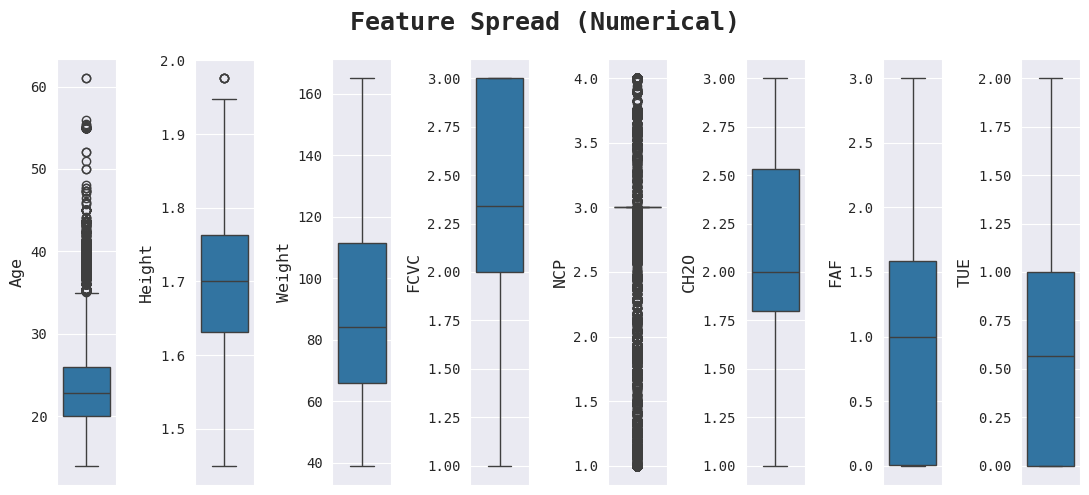

In [24]:
# Plots for analysing the feature spread of the numerical columns

fig, axs = plt.subplots(1, 8, figsize=(max_fig_width, 5))
for ax, column in zip(flatten(axs), numerical_features):
    sns.boxplot(y=column, data=ds_source, ax=ax)
conclude_plot("Feature Spread (Numerical)")

**Observation**:
* Age exhibits significant outliers extending up to the early 60s, while the interquartile range (IQR) is very tight, concentrated between roughly 20 and 24.
* Height and Weight show symmetrical spread and a clean distribution with minimal or no significant outliers.
* NCP (Number of Main Meals) has an extremely small IQR (median and quartiles are near 3) but contains numerous outliers spanning its entire range from 1 to 4.
* FCVC, CH20, FAF, and TUE have large interquartile ranges (IRQs) relative to their total range, indicating a wide spread of data across the possible values. TUE (Time Using Technology) is highly skewed, with the median near the bottom of the box.

**Inference**:
* The dataset's numerical features are generally well-contained but show distinct issues: Age and NCP are primarily characterized by a high number of outliers against a very concentrated central body, while the other features show a generally even, broad spread of values.

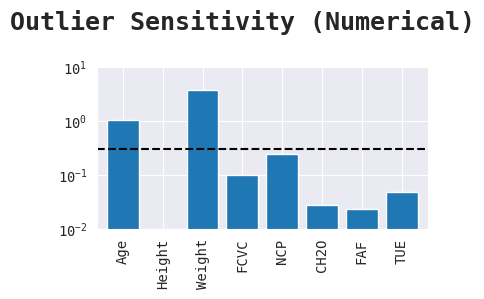

In [25]:
# Plot for analyzing the sensitivity of the numerical features to outliers

plt.figure(figsize=sml_fig)
_ds_num = ds_source[numerical_features]
(_ds_num.mean() - _ds_num.median()).abs().plot(kind='bar', width=0.8)
plt.yscale('log'), plt.ylim(0.01, 10)
plt.axhline(0.3, color='black', linestyle='--')
conclude_plot("Outlier Sensitivity (Numerical)")

**Observation**:
* Weight and Age exhibit the highest outlier sensitivity, significantly exceeding the dashed baseline, indicating extreme values heavily influence their statistics. Height shows near-zero sensitivity, while the remaining features (FCVC, NCP, CH20, FAF, TUE) all fall well below the baseline.

**Inference**:
* Weight and Age are the two features most vulnerable to distortion by outliers and will require the most attention during the data preprocessing or cleaning phase. Conversely, Height is highly robust, and the other features are relatively stable against extreme values.

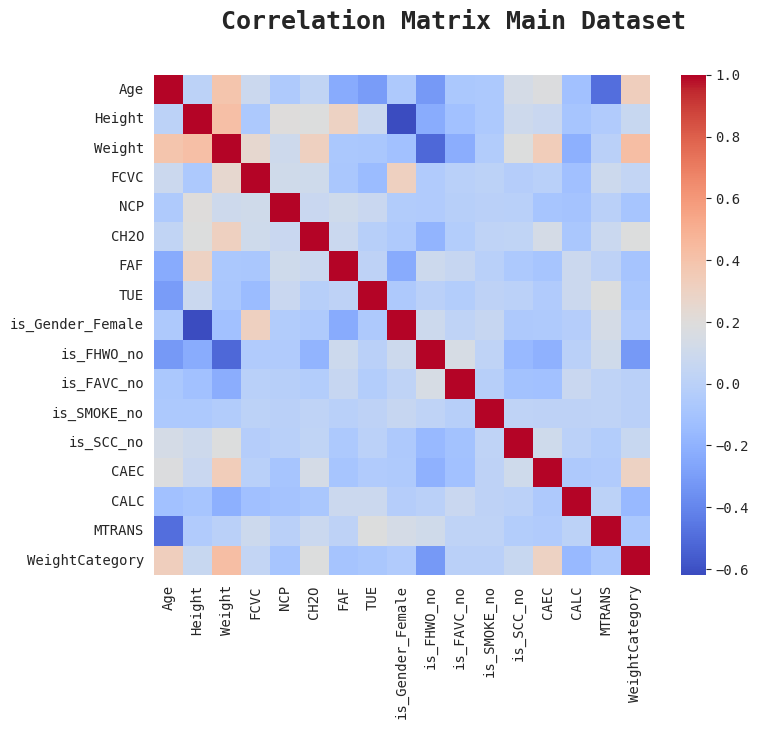

In [26]:
plt.figure(figsize=(8, 6.5))
_ds_relations = apply_pipeline([
    (pop_drop_column, 'id', True),
    (pop_binarize, binary_features, True),
    (pop_ordinal_encode, nary_features, True),
    (pop_ordinal_encode, 'WeightCategory', True),
    (pop_box_cox_transform, 'Age', False),
    (pop_standardize, numerical_features, False),
], ds_source, to_numpy=False)[1]
_corr_matrix = _ds_relations.corr(numeric_only=True)
sns.heatmap(_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
conclude_plot("Correlation Matrix Main Dataset", True)

**Observation**:
Weight shows strong positive correlations with height and age, and naturally increases with the weight category. Height is negatively correlated with being female, indicating that females tend to be shorter. Individuals without a family history of overweight generally weigh less. Age is negatively related to physical activity, calorie intake, and technology use, suggesting that older individuals are less active and spend less time on screens. Physical activity is higher among younger and taller individuals. Females show slightly higher vegetable consumption, reflecting healthier eating patterns.

**Inference**:
* Age and lifestyle: Older individuals appear less active and engage less in screen time.
* Gender differences: Females are shorter, more likely to eat vegetables, and less physically active on average.
* Weight factors: Weight is primarily driven by height and family history of overweight.
* Health behavior: Higher physical activity (FAF) links to lower weight and younger age.
* Diet correlation: Vegetable consumption is not strongly tied to weight but shows mild gender trends.

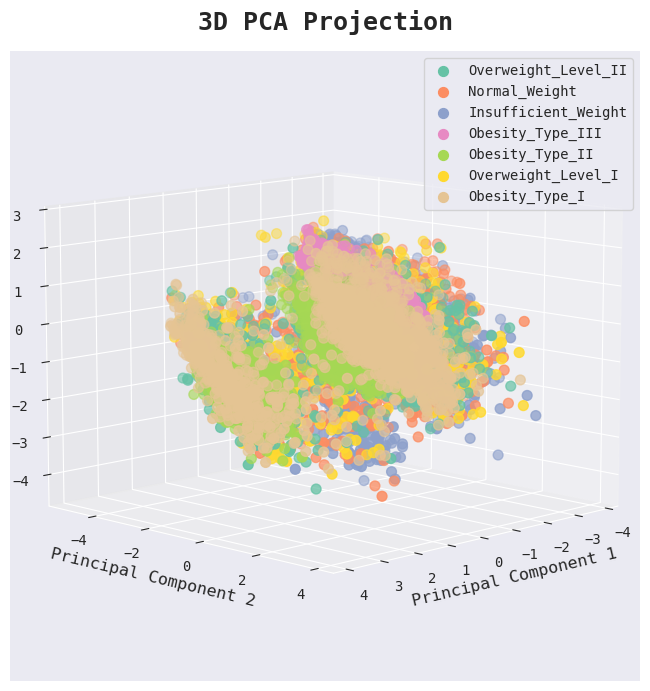

In [27]:
_pca = skl.decomposition.PCA(n_components=3).fit_transform(_ds_relations.drop(columns='WeightCategory'))
_ds_pca = pd.DataFrame(data=_pca, columns=['PC1', 'PC2', 'PC3'])
_ds_pca['Class'] = ds_source['WeightCategory']
fig = plt.figure(figsize=(max_fig_width, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=45)
colors = sns.color_palette("Set2", len(_ds_pca['Class'].unique()))
for i, label in enumerate(_ds_pca['Class'].unique()):
    subset = _ds_pca[_ds_pca['Class'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=label, s=50, color=colors[i])
ax.set_xlabel('Principal Component 1'), ax.set_ylabel('Principal Component 2'), ax.set_zlabel('Principal Component 3')
ax.legend()
conclude_plot('3D PCA Projection')

**Observation**:
The PCA projection shows a large degree of overlap among most classes, with no clearly separated clusters. Categories such as Normal Weight, Overweight, and Obesity Types appear to blend into one another, indicating that their feature distributions are similar in the reduced 3D space.

**Inference**:
This overlap suggests that the variables contributing to weight classification are continuous and interrelated, making sharp boundaries between classes difficult to capture with PCA. It also implies that while PCA captures overall variance, it may not fully separate weight categories—nonlinear methods (e.g., t-SNE or UMAP) might reveal clearer class distinctions.

## Data Pre-Processing

### Handling 'Age' Feature

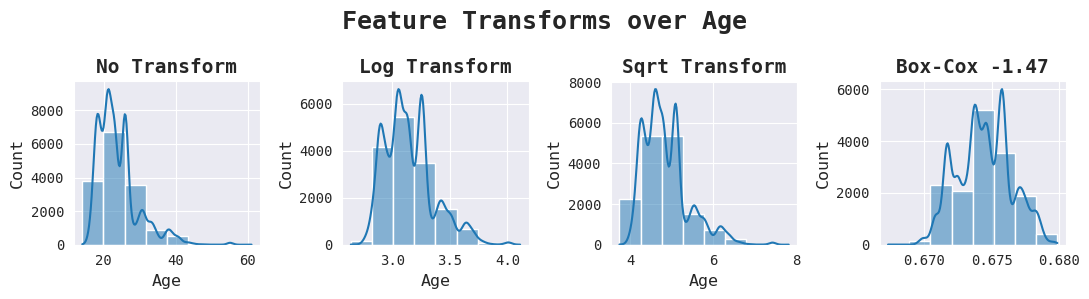

In [28]:
# Analyzing the impact of various data transformation techniques on 'Age' feature in the dataset

fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_bclam, _bcage = pop_box_cox_transform(ds_source['Age'])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['Age']],
        ['Log Transform', pop_log_transform(ds_source['Age'])[1]],
        ['Sqrt Transform', pop_root_transform(ds_source['Age'])[1]],
        ['Box-Cox %.2f' % _bclam, _bcage],
)):
    sns.histplot(data, kde=True, bins=8, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Feature Transforms over Age")

**Observation** 

The Age feature is originally multimodal and heavily right-skewed. Both the Log and Sqrt transforms reduce skewness but fail to normalize the distribution effectively. The Box-Cox Transform with $\lambda = -1.47$ is the most successful at achieving a symmetrical shape.

**Inference**

The Box-Cox transformation with $\lambda = -1.47$ is the optimal choice for preprocessing the Age feature, as it best corrects the skewness and shifts the distribution closest to a more normalized form suitable for modeling.

### Handling 'NCP' Feature

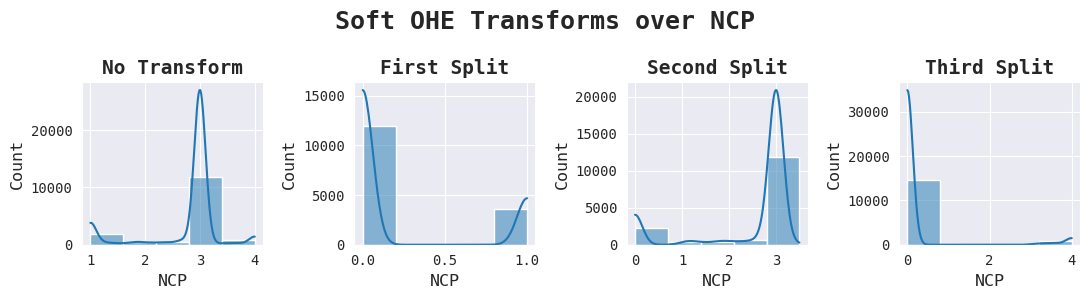

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_, _scd_ncp = pop_soft_ohe(ds_source['NCP'], [1, 3, 3.5])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['NCP']],
        ['First Split', _scd_ncp[0]],
        ['Second Split', _scd_ncp[1]],
        ['Third Split', _scd_ncp[2]],
)):
    sns.histplot(data, kde=True, bins=5, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Soft OHE Transforms over NCP")

**Observation**

The visual analysis confirms that the original NCP (Main Meals Count) feature is highly discrete and clustered, overwhelmingly dominated by the value 3. The Soft OHE Transforms (Split 1, 2, and 3) do not produce a Gaussian or uniform distribution; instead, they primarily create step-function binaries that distinguish the dominant value from the remaining counts. This suggests the transformation is not effectively smoothing the distribution.

**Inference**

While the Soft OHE Transform visually appears suboptimal compared to a simple integer-to-dummy variable encoding, it creates three novel numerical features that capture complex, potentially non-linear thresholds ($<1$, $1-3$, $>3.5$). Since the predictive value of these non-linear feature combinations can only be confirmed empirically by the model, we will retain the Soft OHE as a preprocessing option. This approach allows the model to test whether these derived splits offer a performance advantage over standard One-Hot Encoding in separating the final risk categories.

### Experimenting with Optuna

In [226]:
# def perform_scoped_optuna():
#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     targetMap = {
#         'Insufficient_Weight': 0, 'Normal_Weight': 1,
#         'Overweight_Level_I': 2, 'Overweight_Level_II': 3,
#         'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6
#     }
#     targetMap_reversed = {v: k for k, v in targetMap.items()}
#
#     def cross_val_score_pipeline(X_tr, y_tr, pipeline, skf, verbose=False):
#         X = X_tr.copy()
#         y = y_tr.copy()
#         val_scores = []
#
#         for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#             model = skl.base.clone(pipeline)
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_val)
#             acc = skl.metrics.accuracy_score(y_val, y_pred)
#             val_scores.append(acc)
#
#             if verbose:
#                 print(f"FOLD {fold}: Accuracy = {acc:.5f}")
#
#         mean_acc = np.mean(val_scores)
#         if verbose:
#             print(f"Mean CV Accuracy: {mean_acc:.5f}")
#         return mean_acc
#
#     def xgb_pipeline(df_train, df_test, xgb_model):
#         X_train = df_train.copy()
#         X_test = df_test.copy()
#
#         # Drop ID if exists
#         if 'id' in X_train.columns:
#             X_train = X_train.drop(columns=['id'])
#         if 'id' in X_test.columns:
#             X_test = X_test.drop(columns=['id'])
#
#         y_train = X_train.pop('WeightCategory').map(targetMap)
#
#         # numeric and categorical columns
#         numeric_cols = list(X_train.select_dtypes(exclude='object').columns)
#         categorical_cols = list(X_train.select_dtypes(include='object').columns)
#
#         numeric_cols_without_age = [c for c in numeric_cols if c != 'Age']
#
#         # Numeric transformer
#         num_transformer = skl.compose.ColumnTransformer([
#             ('boxcox', skl.preprocessing.PowerTransformer(method='box-cox'), ['Age']),
#             ('scale', skl.preprocessing.StandardScaler(), numeric_cols_without_age)
#         ])
#
#         # Categorical transformer
#         cat_transformer = skl.preprocessing.OrdinalEncoder()
#
#         # Full preprocessor
#         preprocessor = skl.compose.ColumnTransformer([
#             ('num', num_transformer, numeric_cols),
#             ('cat', cat_transformer, categorical_cols)
#         ])
#
#         pipeline = skl.pipeline.make_pipeline(preprocessor, xgb_model)
#         return X_train, y_train, X_test, pipeline
#
#     def objective(trial, pipeline, X_train, y_train, skf):
#         params = {
#             "max_depth": trial.suggest_int("max_depth", 2, 20),
#             "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#             "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#             "subsample": trial.suggest_float("subsample", 0.7, 1.0),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#             "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0),
#             "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0),
#             "gamma": trial.suggest_float("gamma", 0.0, 5.0)
#         }
#         pipeline.named_steps['xgbclassifier'].set_params(**params)
#
#         mean_acc = cross_val_score_pipeline(X_train, y_train, pipeline, skf)
#         print(f"Trial {trial.number}: Accuracy = {mean_acc:.5f}")
#         return mean_acc
#
#     xgb_model = xgb.XGBClassifier(n_estimators=500, n_jobs=-1, eval_metric="mlogloss")
#
#     X_train, y_train, X_test, pipeline = xgb_pipeline(ds_source, ds_test, xgb_model)
#     skf = skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
#     study = optuna.create_study(direction="maximize")
#     study.optimize(
#         functools.partial(objective, pipeline=pipeline, X_train=X_train, y_train=y_train, skf=skf),
#         n_trials=30
#     )
#
#     trial = study.best_trial
#     print("\nBest CV Accuracy:", trial.value)
#     print("Best Hyperparameters:")
#     for k, v in trial.params.items():
#         print(f"{k}: {v}")
#
#     best_params = trial.params
#     xgb_model_final = xgb.XGBClassifier(
#         n_estimators=500,
#         n_jobs=-1,
#         use_label_encoder=False,
#         eval_metric="mlogloss",
#         **best_params
#     )
#
#     X_train, y_train, X_test, final_pipeline = xgb_pipeline(ds_source, ds_test, xgb_model_final)
#     final_pipeline.fit(X_train, y_train)
#
#     # ---------------------
#     # Predict on test set
#     # ---------------------
#     test_preds_numeric = final_pipeline.predict(X_test)
#     test_preds_labels = [targetMap_reversed[i] for i in test_preds_numeric]
#
#     submission = pd.DataFrame({'id': ds_test['id'], 'WeightCategory': test_preds_labels})
#     submission.to_csv("submissions/boxcox_std_label.csv", index=False)
#     print("\nSaved predictions to submissions/boxcox_std_label.csv")
#
#
# perform_scoped_optuna()

Trial 0: Accuracy = 0.89036
Trial 1: Accuracy = 0.87845
Trial 2: Accuracy = 0.90279
Trial 3: Accuracy = 0.89204
Trial 4: Accuracy = 0.87865
Trial 5: Accuracy = 0.87980
Trial 6: Accuracy = 0.78137
Trial 7: Accuracy = 0.90259
Trial 8: Accuracy = 0.90092
Trial 9: Accuracy = 0.87549
Trial 10: Accuracy = 0.86358
Trial 11: Accuracy = 0.90749
Trial 12: Accuracy = 0.90504
Trial 13: Accuracy = 0.90021
Trial 14: Accuracy = 0.90652
Trial 15: Accuracy = 0.89326
Trial 16: Accuracy = 0.90202
Trial 17: Accuracy = 0.88611
Trial 18: Accuracy = 0.82399
Trial 19: Accuracy = 0.89506
Trial 20: Accuracy = 0.88991
Trial 21: Accuracy = 0.90356
Trial 22: Accuracy = 0.90601
Trial 23: Accuracy = 0.90581
Trial 24: Accuracy = 0.90729
Trial 25: Accuracy = 0.89120
Trial 26: Accuracy = 0.89654
Trial 27: Accuracy = 0.90671
Trial 28: Accuracy = 0.88933
Trial 29: Accuracy = 0.90678

Best CV Accuracy: 0.907487568834348
Best Hyperparameters:
max_depth: 20
min_child_weight: 3
learning_rate: 0.0990410027198635
subsample: 0.

C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:51:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Saved predictions to submissions/boxcox_std_label.csv


### Experimenting with Smote

In [255]:
# def calculate_demons_constant(n_scaler, depth):
#     constant = 1
#     for i in range(depth):
#         constant += 1 / (n_scaler + 10 ** i)
#     return constant
#
#
# def perform_scoped_smote():
#     yix = ds_source.drop(columns=target_columns, axis=1)
#     yaw = ds_source[target_columns]
#
#     categorical_features = yix.select_dtypes(include=['object', 'category']).columns
#     categorical_indices = [yix.columns.get_loc(col) for col in categorical_features]
#
#     smote_nc = SMOTENC(
#         categorical_features=categorical_indices,
#         sampling_strategy='auto',
#         random_state=current_seed
#     )
#
#     ds_resampled, ds_resampled_targets = smote_nc.fit_resample(yix, yaw)
#     ds_resampled[target_columns] = ds_resampled_targets
#     display(ds_resampled.head())
#     ds_resampled.to_csv("train1.csv", index=False)
#
#
# perform_scoped_smote()

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## Data Pipelining

#### For Regression Based Models

In [30]:
regression_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory'], True),
        (pop_binarize, binary_features, True),
        (pop_one_hot_encode, nary_features, True),
    ],
    [  # Permutable ones
        [  # No Chill
        ],
        [  # Simple Life
            (pop_box_cox_transform, ['Age'], False),
            (pop_standardize, numerical_features, False),
        ],
        [  # Encoded Q-Conts
            (pop_box_cox_transform, ['Age'], False),
            (pop_standardize, gaussian_features, False),
            (pop_round, partial_features, False),
            (pop_one_hot_encode, partial_features, False),
        ],
        [  # Soft Hot Encode
            (pop_box_cox_transform, 'Age', False),
            (pop_standardize, gaussian_features, False),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), 'FCVC', True),
            (prepare_pop(pop_soft_ohe, [1, 3, 4]), 'NCP', True),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), 'CH2O', True),
            (prepare_pop(pop_soft_ohe, [0, 1, 2, 3]), 'FAF', True),
            (prepare_pop(pop_soft_ohe, [0, 1, 2]), 'TUE', True),
        ],
    ],
]
regression_pipeline_derived = regression_pipeline.copy()
regression_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory'], True),
    (pop_derived_features, None, False),
    (pop_binarize, binary_features, True),
    (pop_one_hot_encode, nary_features, True),
    (pop_standardize, numerical_derived_features, True),
    (pop_binarize, binary_derived_features, True),
]

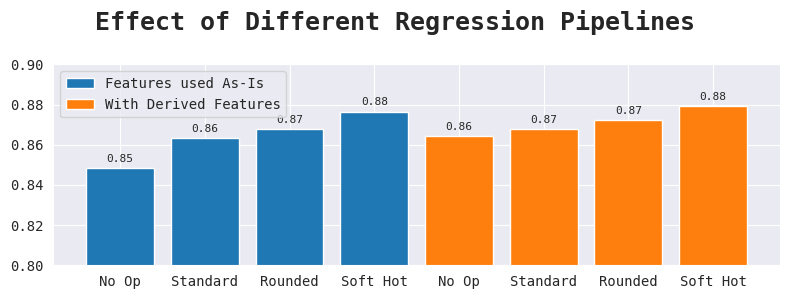

In [31]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'].to_numpy())[1]
_scores = []

for pipeline_variants in [regression_pipeline, regression_pipeline_derived]:
    for pipeline in iterate_pipeline_variants(pipeline_variants):
        args, ds_sample = apply_pipeline(pipeline, ds_source)
        model = skl.linear_model.LogisticRegression(max_iter=5000)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)
            model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))


def plot_variants(topic, titles):
    plt.figure(figsize=wid_fig)
    plt.bar(range(len(titles)), _scores[:len(titles)], label='Features used As-Is')
    plt.bar(range(len(titles), 2 * len(titles)), _scores[len(titles):], label='With Derived Features')
    for i, score in enumerate(_scores):
        plt.text(i, score + 0.002, f'{score:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xticks(range(len(_scores)), titles * 2)
    plt.ylim(min(0.8, np.min(_scores)), max(0.9, np.max(_scores)))
    plt.legend()
    conclude_plot(f"Effect of Different {topic} Pipelines")


plot_variants("Regression", ['No Op', 'Standard', 'Rounded', 'Soft Hot'])

**Observation**

The Soft OHE transformation yields the highest and identical accuracy ($\approx 0.88$) for both the "Features used As-Is" and the "With Derived Features" groups. All other preprocessing methods show the "With Derived Features" group slightly outperforming the "As-Is" group, but the overall top score is achieved with Soft OHE.

**Inference**

The Soft OHE technique appears to be the most robust and effective preprocessing method, as it maximizes the model's performance regardless of whether complex derived features are included or not. Since the derived features do not provide an additional lift when using the best transformation (Soft OHE), the optimal and simplest final pipeline should focus on applying Soft OHE to the base features, maximizing performance while minimizing feature engineering complexity.

#### For Tree Based Models

In [32]:
tree_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory'], True),
        (pop_binarize, binary_features, True),
    ],
    [  # Permutable ones
        [  # Ordinally Encoded
            (pop_ordinal_encode, nary_features, True),
        ],
        [  # One Hot Encoded
            (pop_one_hot_encode, nary_features, True),
        ],
    ],
]
tree_pipeline_derived = tree_pipeline.copy()
tree_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory'], True),
    (pop_derived_features, None, False),
    (pop_binarize, binary_features, True),
    (pop_binarize, binary_derived_features, True),
]

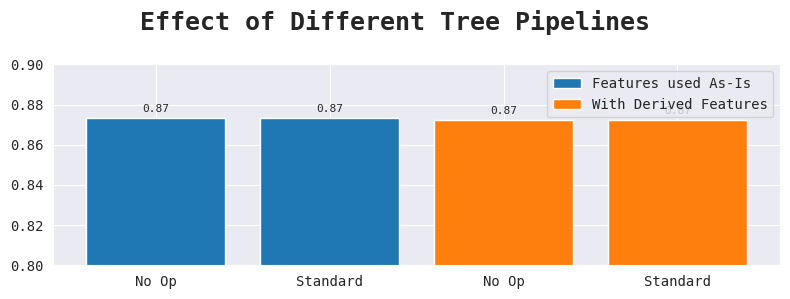

In [33]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'].to_numpy())[1]
_scores = []

for pipeline_variants in [tree_pipeline, tree_pipeline_derived]:
    for pipeline in iterate_pipeline_variants(pipeline_variants):
        args, ds_sample = apply_pipeline(pipeline, ds_source)
        model = skl.tree.DecisionTreeClassifier(max_depth=7)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plot_variants("Tree", ['No Op', 'Standard'])

**Observation**

The scores for the tree-based model are consistently high ($\approx 0.87$). Crucially, the scores within both the base and derived feature groups are virtually identical across all transformation types.

**Inference**

Feature Engineering is paramount and provides the primary benefit for the tree model. Since tree-based algorithms are invariant to scaling (Standard/MinMax), any transformation on numerical features is unnecessary. The final pipeline should include Derived Features but use the simplest transformation ("No Op" or no scaling) to maximize efficiency without compromising accuracy.

#### For Distance Based Models

In [34]:
distance_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory'], True),
        (pop_binarize, binary_features, True),
        (pop_one_hot_encode, nary_features, True),
    ],
    [  # Permutable ones
        [  # No Chill
        ],
        [  # Box Cox
            (pop_box_cox_transform, gaussian_features, False),
        ],
        [  # Standardize
            (pop_standardize, numerical_features, False),
        ],
        [  # All-In
            (pop_box_cox_transform, gaussian_features, False),
            (pop_standardize, numerical_features, False),
        ],
    ],
]
distance_pipeline_derived = distance_pipeline.copy()
distance_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory'], True),
    (pop_derived_features, None, False),
    (pop_binarize, binary_features, True),
    (pop_one_hot_encode, nary_features, True),
    (pop_standardize, numerical_derived_features, True),
    (pop_binarize, binary_derived_features, True),
]

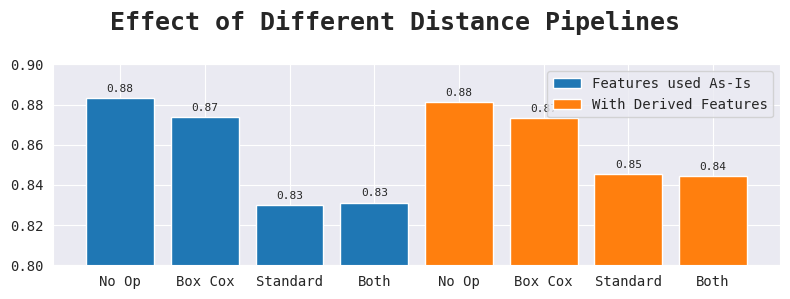

In [35]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'].to_numpy())[1]
_scores = []

for pipeline_variants in [distance_pipeline, distance_pipeline_derived]:
    for pipeline in iterate_pipeline_variants(pipeline_variants):
        args, ds_sample = apply_pipeline(pipeline, ds_source)
        model = skl.neighbors.KNeighborsClassifier(n_neighbors=5)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plot_variants("Distance", ['No Op', 'Box Cox', 'Standard', 'Both'])

**Observation**

Surprisingly, adding in any kind of transformation affects the KNN model negatively. Therefore, it's advisable to not touch any of the features in the distance-based model.

**Inference**

It is highly likely that the features and their scales contribute to the natural order with which the distance is calculated between two points. The range in these feature is in sync with how important of a factor they hold in similarity.

#### For Probability Based Models

In [36]:
probability_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory'], True),
        (pop_binarize, binary_features, True),
        (pop_ordinal_encode, nary_features, True),
    ],
    [  # Permutable ones
        [  # OHE
            (pop_standardize, numerical_features, False),
        ],
        [  # OHE
            (pop_minmax, numerical_features, False),
        ],
        [  # OHE
            (pop_epsilon, numerical_features, False),
            (pop_box_cox_transform, numerical_features, False),
            (pop_standardize, numerical_features, False),
        ],
        [  # OHE
            (pop_epsilon, numerical_features, False),
            (pop_box_cox_transform, numerical_features, False),
            (pop_minmax, numerical_features, False),
        ],
    ],
]
probability_pipeline_derived = probability_pipeline.copy()
probability_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory'], True),
    (pop_derived_features, None, False),
    (pop_binarize, binary_features, True),
    (pop_ordinal_encode, nary_features, True),
    (pop_standardize, numerical_derived_features, True),
    (pop_binarize, binary_derived_features, True),
]

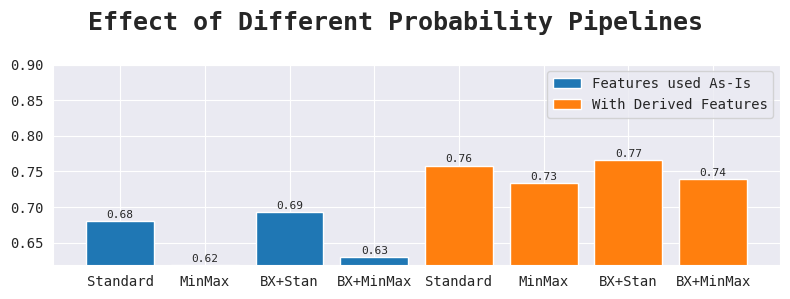

In [37]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'].to_numpy())[1]
_scores = []

for pipeline_variants in [probability_pipeline, probability_pipeline_derived]:
    for pipeline in iterate_pipeline_variants(pipeline_variants):
        args, ds_sample = apply_pipeline(pipeline, ds_source)
        model = skl.naive_bayes.GaussianNB(var_smoothing=0.01)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plot_variants("Probability", ['Standard', 'MinMax', 'BX+Stan', 'BX+MinMax'])

**Observation**

In general, the application of different transformations to the features does not affect the performance by a high margin. However, the introduction of derived features sure does take a big toll on the loss.

**Inference**

Standard scaling stands better than minmax scaling, which coupled with derived-features provides the best pipeline to work on.

## Modelling

#### Experiment Setup

#### Train-Test Splitting

In [114]:
def create_environment(_pipeline, test_size=0.3, ds_source_in=ds_source):
    _data_x, _data_y = ds_source_in, ds_source_in['WeightCategory'].to_numpy()
    _data_y_codex, _data_y = pop_ordinal_encode(_data_y)

    _train_x, _test_x, _train_y, _test_y = skl.model_selection.train_test_split(
        _data_x, _data_y, test_size=test_size, random_state=current_seed)

    _arguments, _train_x = apply_pipeline(_pipeline, _train_x)
    _, _test_x = apply_pipeline(_pipeline, _test_x, _arguments)

    _, _data_test = apply_pipeline(_pipeline, ds_test)
    _data_test_ids = ds_test['id'].to_numpy()

    return {
        'pipeline': _pipeline, 'arguments': _arguments,
        'data_exp': (_train_x, _test_x, _train_y, _test_y),
        'data_y_codex': _data_y_codex[0],
        'data_sub': (_data_test_ids, _data_test),
    }


def conduct_simple_experiment(name, model, environment, silent=False):
    train_x, test_x, train_y, test_y = environment['data_exp']
    data_test_ids, data_test = environment['data_sub']
    data_y_codex = environment['data_y_codex']
    train_acc, test_acc = evaluate_model(model, train_x, train_y, test_x, test_y, silent)
    save_submission(name, model, data_test_ids, data_test, data_y_codex)
    if not silent: chime.info()
    return train_acc, test_acc


def conduct_grid_search_experiment(name, search_space, model_supplier, environment,
                                   skip_control=None, derived_parameters=None, verbose=-1):
    train_x, test_x, train_y, test_y = environment['data_exp']
    data_test_ids, data_test = environment['data_sub']
    data_y_codex = environment['data_y_codex']

    start_time = time.perf_counter()

    history = []

    pbar = [dict(zip(search_space.keys(), values)) for values in itertools.product(*search_space.values())]
    if verbose == -1: pbar = tqdm(pbar)

    for parameters in pbar:
        if skip_control is not None and skip_control(parameters):
            continue
        if derived_parameters is not None:
            derived_parameters(parameters)

        key = ",".join(["%s=%s" % (k, v) for k, v in parameters.items()])
        if verbose >= 0:  print("Training Model with configurations", key)
        if verbose == -1: pbar.set_description("Processing %s" % key)

        cons_args = inspect.signature(model_supplier).parameters.keys()
        if 'verbose' in cons_args and verbose > 0: parameters['verbose'] = verbose
        if 'n_jobs' in cons_args: parameters['n_jobs'] = 15
        if 'random_state' in cons_args: parameters['random_state'] = current_seed
        if 'cv' in cons_args: parameters['cv'] = 5

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                model = model_supplier(**parameters)
                model.fit(train_x, train_y)
                history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                                      'val score': model.score(test_x, test_y)}])
        except Exception as e:
            if verbose >= 1: print("This config is not compatible:", e)

    elapsed_time = time.perf_counter() - start_time
    best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])

    save_submission(name + '_' + best_config, best_model, data_test_ids, data_test, data_y_codex)

    displayMD(header(4, kv('Best Val Accuracy', best_score)))
    displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))

    chime.success()
    return history, best_score, best_config, best_model, elapsed_time


def conduct_grid_search_experiment_v2(name, search_space, model_supplier, environment, cv=5, verbose=1, fresh=False):
    train_x, test_x, train_y, test_y = environment['data_exp']
    data_test_ids, data_test = environment['data_sub']
    data_y_codex = environment['data_y_codex']

    if not fresh:
        try:
            history, best_score, best_config, best_model, elapsed_time, search_space_size = joblib.load(
                f"dumps/history_{name}.pkl")
            displayMD(header(3, f"Evaluation: {name}"))
            displayMD(header(4, kv('Best Val Accuracy', best_score)))
            displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))
            displayAUCScore(test_x, test_y, best_model)
            plot_confusion_matrix(test_y, best_model.predict(test_x), target_labels, title=f"Confusion Matrix: {name}")
            return history, best_score, best_config, best_model, elapsed_time, search_space_size
        except:
            pass

    start_time = time.perf_counter()

    history = []

    parameters = {}
    cons_args = inspect.signature(model_supplier).parameters.keys()
    if 'verbose' in cons_args and verbose > 0: parameters['verbose'] = verbose
    if 'random_state' in cons_args: parameters['random_state'] = current_seed
    model = model_supplier(**parameters)

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            gs = skl.model_selection.GridSearchCV(model, search_space, cv=cv, verbose=max(0, verbose), n_jobs=12,
                                                  return_train_score=True)
            gs.fit(train_x, train_y)
            history.extend([[",".join(["%s=%s" % (k, v) for k, v in p.items()]),
                             {'model': 'ISE', 'train score': train_sc, 'val score': test_sc,
                              'train_time': train_time, 'pred_time': pred_time, }]
                            for train_sc, test_sc, train_time, pred_time, p in
                            zip(gs.cv_results_['mean_train_score'], gs.cv_results_['mean_test_score'],
                                gs.cv_results_['mean_fit_time'], gs.cv_results_['mean_score_time'],
                                gs.cv_results_['params'])
                            if not np.isnan(test_sc)])
    except Exception as e:
        if verbose >= 1: print("Something went wrong", e)

    elapsed_time = time.perf_counter() - start_time
    best_score, best_config, best_model = gs.best_score_, gs.best_params_, gs.best_estimator_
    best_config = ",".join(["%s=%s" % (k, v) for k, v in best_config.items()])
    search_space_size = len(gs.cv_results_['params']) * gs.cv

    save_submission(name + '_' + best_config, best_model, data_test_ids, data_test, data_y_codex)

    displayMD(header(3, f"Evaluation: {name}"))
    displayMD(header(4, kv('Best Val Accuracy', best_score)))
    displayMD(header(4, kv('Time Elapsed', f"{elapsed_time:.4f} seconds")))
    displayAUCScore(test_x, test_y, best_model)
    plot_confusion_matrix(test_y, best_model.predict(test_x), target_labels, title=f"Confusion Matrix: {name}")

    chime.success()
    joblib.dump((history, best_score, best_config, best_model, elapsed_time, search_space_size),
                f"dumps/history_{name}.pkl")
    return history, best_score, best_config, best_model, elapsed_time, search_space_size


def plot_model_comparsion(name, history):
    plt.figure(figsize=sml_fig)
    _hist = sorted([[x[1]['val score'], x] for x in history])
    if len(_hist) <= 30:
        for idx, (score, _) in enumerate(_hist):
            plt.bar(idx, score)
    else:
        for idx, (score, _) in enumerate(_hist[:15]):
            plt.bar(idx, score)
        for idx, (score, _) in enumerate(_hist[-15:]):
            plt.bar(idx + 16, score)

    print(_hist[-1][1][0])
    plt.xlabel(_hist[-1][1][0])
    plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
    conclude_plot(f"Best {name} Config")

In [96]:
gss = skl.model_selection.GridSearchCV(skl.linear_model.LogisticRegression(),
                                       {'max_iter': [4, 5, 6]}, return_train_score=True)

In [97]:
gss.fit(ds_source['Age'].to_numpy().reshape((-1, 1)), ds_source['WeightCategory'])


C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

,estimator,LogisticRegression()
,param_grid,"{'max_iter': [4, 5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,penalty,'l2'


In [98]:
gss.cv_results_['mean_train_score']

array([0.19204275, 0.19204275, 0.19204275])

In [38]:
history_tts = pd.DataFrame(columns=['model', 'split ratio', 'current seed', 'metric type', 'metric value'])

for split_ratio in [0.50, 0.30, 0.20, 0.10, 0.05, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0005]:
    max_test_acc = 0.0
    row_train = []
    row_test = []
    for i in range(10):
        reset_seed(np.random.randint(1000000))
        pipeline = select_pipeline_variation(regression_pipeline_derived, 3)
        regression_environment = create_environment(pipeline, split_ratio)
        model = skl.linear_model.LogisticRegression(penalty=None, solver='newton-cg')
        train_acc, test_acc = conduct_simple_experiment("TTS_LR_%f" % split_ratio, model, regression_environment, True)
        if test_acc > max_test_acc:
            max_test_acc = test_acc
            row_train = ["LR", "%.e" % split_ratio, current_seed, "train", train_acc]
            row_test = ["LR", "%.e" % split_ratio, current_seed, "test", test_acc]
    history_tts.loc[len(history_tts)] = row_train
    history_tts.loc[len(history_tts)] = row_test

reset_seed()
chime.success()

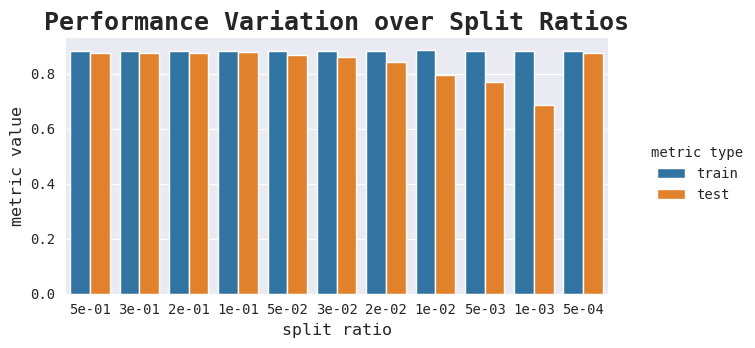

In [39]:
g = sns.catplot(
    data=history_tts, kind="bar",
    x="split ratio", y="metric value", hue="metric type",
    errorbar="sd"
)
g.fig.set_size_inches(*wid_fig)
plt.title("Performance Variation over Split Ratios", **font_suptitle)
conclude_plot(None, True)

### Logistic Regression

#### Data Preparation for Regression Based Models

In [101]:
regression_environment = create_environment(select_pipeline_variation(regression_pipeline, 3))

#### Simple LR Example

### Evaluation: LogisticRegressionCV

#### **Train Accuracy:** `0.8802`

#### **Val Accuracy:** `0.8783`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9842`

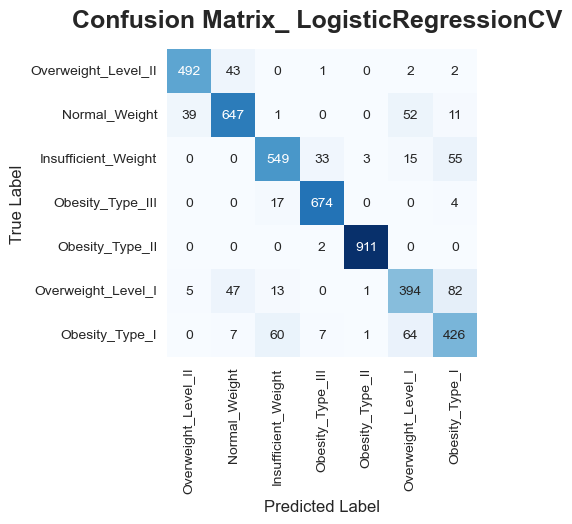

(0.8801618688494436, 0.8783261802575107)

In [102]:
conduct_simple_experiment("SimpleLRModel", skl.linear_model.LogisticRegressionCV(cv=5, max_iter=10000),
                          regression_environment)

#### Grid Searched Logistic Regression

### Evaluation: GSLR

#### **Best Val Accuracy:** `0.8748290877560299`

#### **Time Elapsed:** `179.3583 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9843`

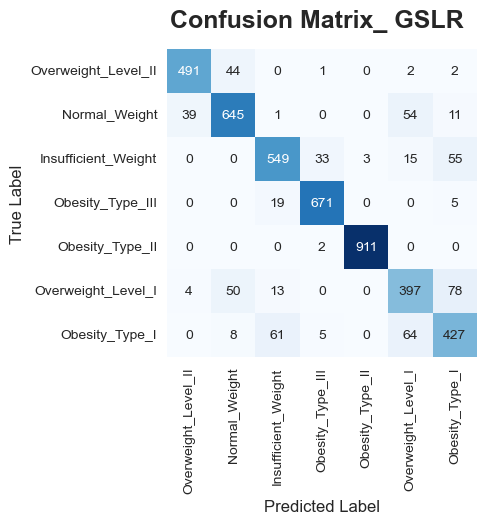

In [115]:
history_lr, *meta_lr = conduct_grid_search_experiment_v2("GSLR", search_space={
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'C': [1, 0.1, 0.01],
    'l1_ratio': [0.25, 0.5, 0.75],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [1000],
}, model_supplier=skl.linear_model.LogisticRegression, environment=regression_environment, verbose=1)

C=1,l1_ratio=0.75,max_iter=1000,penalty=l1,solver=saga


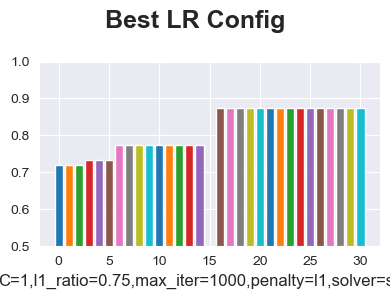

In [116]:
plot_model_comparsion("LR", history_lr)

**Observation**

The Logistic Regression model with Grid Search achieved a Best CV Accuracy of $0.874$, which is only a marginal increase ($\approx 1.001$%) over the initial simple model ($\approx 0.873). The optimal configuration found was penalty=None, C=1.0, solver=saga. The bar plot shows that many different configurations clustered tightly around the optimal score, indicating the model's performance has plateaued. This plateauing performance confirms that the linear model is maxed out and cannot resolve the non-linear confusion between adjacent weight classes (e.g., Overweight Levels). Further tuning is futile. The next step must be to switch to a non-linear model.

### Polynomial Regression

#### Simple PR Example

### Evaluation: Pipeline

#### **Train Accuracy:** `0.9303`

#### **Val Accuracy:** `0.8564`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9767`

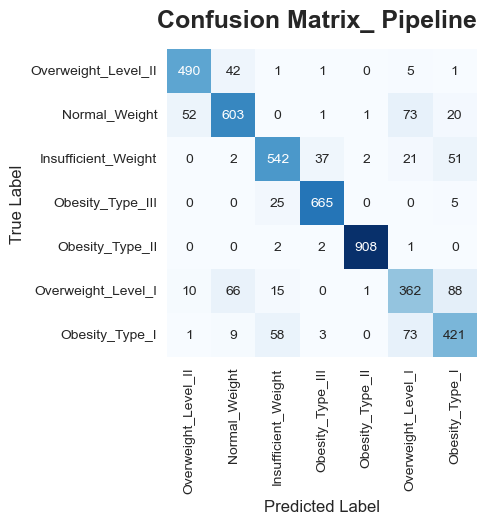

(0.9302860296146418, 0.8564377682403433)

In [109]:
def PolynomialRegressor(**kwargs):
    return skl.pipeline.Pipeline([
        ('poly', skl.preprocessing.PolynomialFeatures(degree=2)),
        ('scale', skl.preprocessing.StandardScaler()),
        ('model', skl.linear_model.LogisticRegression(**kwargs))
    ])


conduct_simple_experiment("SimplePRModel", PolynomialRegressor(max_iter=1000), regression_environment)

#### Grid Searched Polynomial Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### Evaluation: GSPR

#### **Best Val Accuracy:** `0.8589172773318952`

#### **Time Elapsed:** `42.7050 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9793`

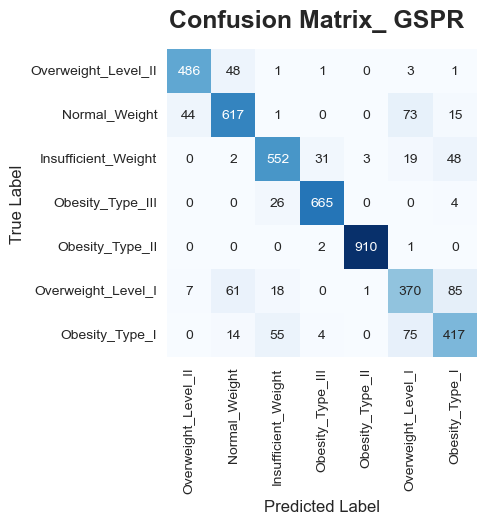

In [120]:
history_pr, *meta_pr = conduct_grid_search_experiment_v2("GSPR", search_space={
    'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'model__C': [1, 0.1, 0.01],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'model__max_iter': [1000],
}, model_supplier=PolynomialRegressor, environment=regression_environment, verbose=1)

model__C=0.1,model__max_iter=1000,model__penalty=l2


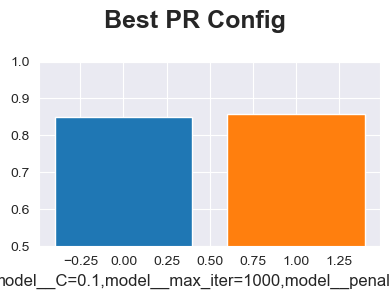

In [121]:
plot_model_comparsion("PR", history_pr)

**Observation**

The Polynomial Logistic Regression achieved a Best CV Accuracy of 84.93%, nowhere as good as a Logistic Regression (87.48%). The optimal penalty=L2 and C=0.5. While the transformation captured some non-linear relationships, the gains are limited, indicating that more non-linear features are not really required.

### Decision Tree

#### Data Preparation for Tree Based Models

In [123]:
tree_environment = create_environment(select_pipeline_variation(tree_pipeline, 0))

#### Simple DT Example

### Evaluation: DecisionTreeClassifier

#### **Train Accuracy:** `0.8837`

#### **Val Accuracy:** `0.8627`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9724`

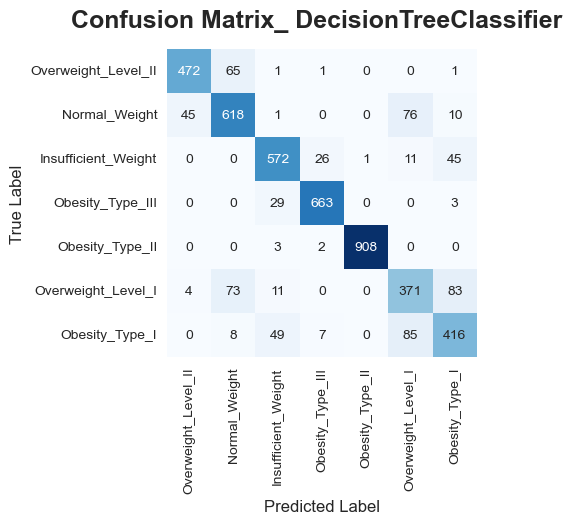

(0.8836567644624299, 0.8626609442060086)

In [124]:
conduct_simple_experiment("SimpleDTModel", skl.tree.DecisionTreeClassifier(max_depth=7), tree_environment)

#### Grid Searched Decision Tree

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


### Evaluation: GSDT

#### **Best Val Accuracy:** `0.8734497351140437`

#### **Time Elapsed:** `16.1798 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9754`

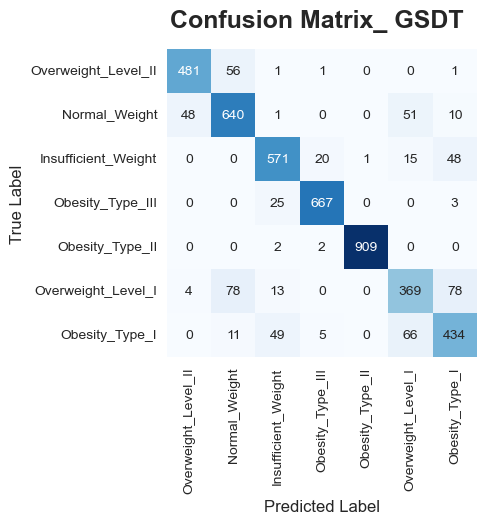

In [125]:
history_dt, *meta_dt = conduct_grid_search_experiment_v2("GSDT", search_space={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': range(5, 21),
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 50, 100],
}, model_supplier=skl.tree.DecisionTreeClassifier, environment=tree_environment, verbose=1)

criterion=gini,max_depth=12,max_features=None,max_leaf_nodes=100,splitter=best


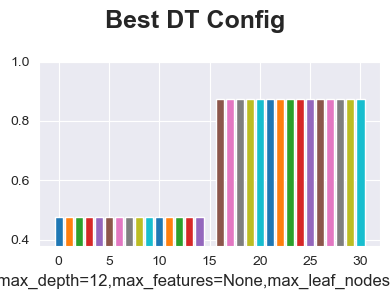

In [126]:
plot_model_comparsion("DT", history_dt)

**Observation**

The Best Validation Accuracy for the Decision Tree is 87.34%. This result is slightly lower than the best Logistic Regression result (87.48%), confirming that a single Decision Tree is not strong enough to outperform the optimized linear model.

### AdaBoost

#### Simple AB Example

### Evaluation: AdaBoostClassifier

#### **Train Accuracy:** `0.6325`

#### **Val Accuracy:** `0.6337`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9228`

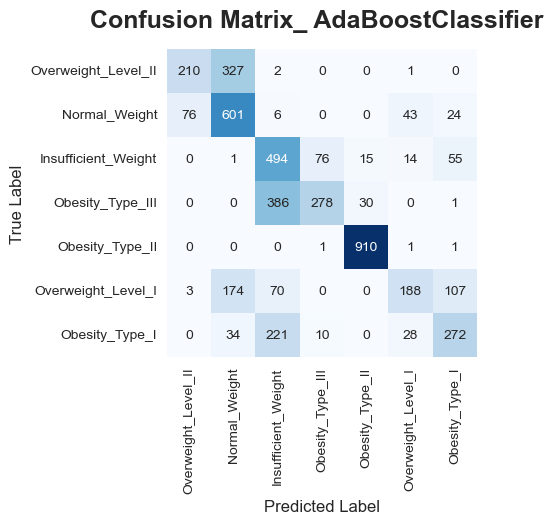

(0.6324841350133358, 0.6336909871244635)

In [127]:
conduct_simple_experiment("SimpleABModel", skl.ensemble.AdaBoostClassifier(), tree_environment)

#### Grid Searched AdaBoost

### Evaluation: GSAB

#### **Best Val Accuracy:** `0.8655396165762566`

#### **Time Elapsed:** `120.9819 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9736`

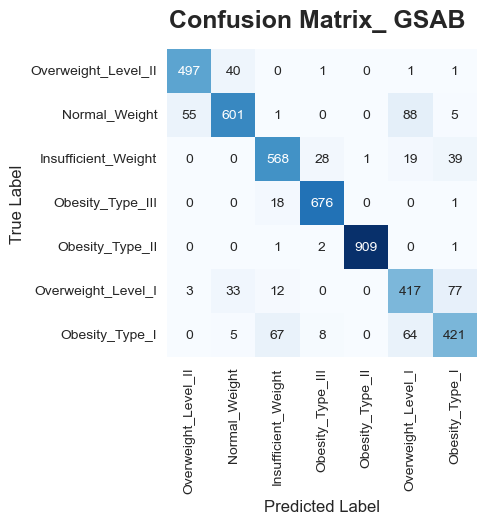

In [129]:
history_ab, *meta_ab = conduct_grid_search_experiment_v2("GSAB", search_space={
    'n_estimators': range(10, 251, 20),
    'learning_rate': [1.0, 0.1],
    'estimator': [
        skl.tree.DecisionTreeClassifier(max_depth=1),
        skl.tree.DecisionTreeClassifier(max_depth=2),
        skl.tree.DecisionTreeClassifier(max_depth=3),
    ],
}, model_supplier=skl.ensemble.AdaBoostClassifier, environment=tree_environment, verbose=1)

estimator=DecisionTreeClassifier(max_depth=3),learning_rate=0.1,n_estimators=230


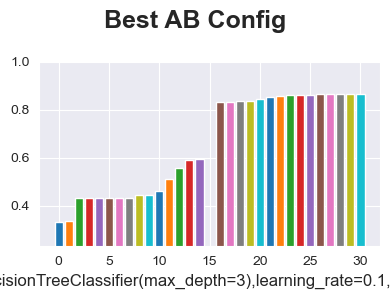

In [130]:
plot_model_comparsion("AB", history_ab)

**Observation**

The AdaBoost Grid Search (GSAB) achieved a Best Validation Accuracy of 86.55%, marking no major improvements over both the best Logistic Regression and Decision Tree models.

The optimal configuration was n_estimators=230, learning_rate=0.1.

### Random Forest

#### Simple RF Example

### Evaluation: RandomForestClassifier

#### **Train Accuracy:** `1.0000`

#### **Val Accuracy:** `0.8968`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9867`

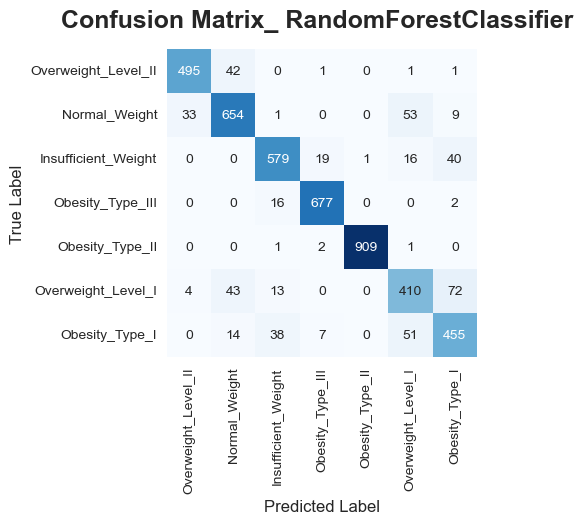

(1.0, 0.8967811158798283)

In [131]:
conduct_simple_experiment("SimpleRFModel", skl.ensemble.RandomForestClassifier(), tree_environment)

#### Grid Searched Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


### Evaluation: GSRF

#### **Best Val Accuracy:** `0.8951541837177087`

#### **Time Elapsed:** `188.9072 seconds`

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


#### **Test Multiclass ROC AUC Score (OVR):** `0.9873`

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


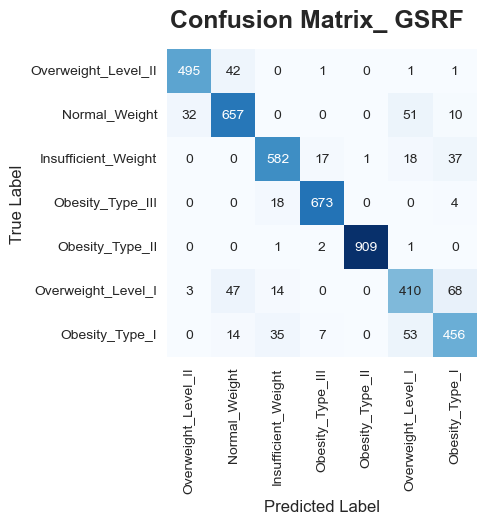

In [132]:
history_rf, *meta_rf = conduct_grid_search_experiment_v2("GSRF", search_space={
    'n_estimators': range(150, 181, 10),
    'max_depth': range(15, 26, 2),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 20, 30],
}, model_supplier=skl.ensemble.RandomForestClassifier, environment=tree_environment, verbose=1)

max_depth=25,max_features=sqrt,max_leaf_nodes=None,n_estimators=180


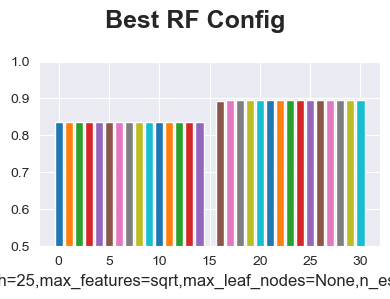

In [133]:
plot_model_comparsion("RF", history_rf)

**Observation**

The Random Forest model reached a Best Validation Accuracy of 89.51 with n_estimators=180 and max_depth=25. The improvement over a single Decision Tree confirms that ensemble averaging effectively reduces variance. However, training time increased noticeably, suggesting diminishing returns for deeper or larger forests.

### XGBoost

#### Simple XGB Example

### Evaluation: XGBClassifier

#### **Train Accuracy:** `0.9931`

#### **Val Accuracy:** `0.8994`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9890`

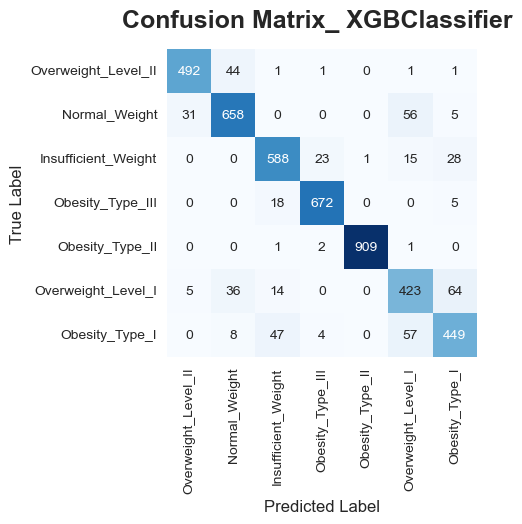

(0.9931021797112113, 0.8993562231759656)

In [134]:
conduct_simple_experiment("SimpleXGBModel",
                          xgb.XGBClassifier(objective='multi:softmax', num_class=n_targets, eval_metric='mlogloss'),
                          tree_environment)

#### Grid Searched XGBoost

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


### Evaluation: GSXGB

#### **Best Val Accuracy:** `0.9056385496304287`

#### **Time Elapsed:** `252.6906 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9904`

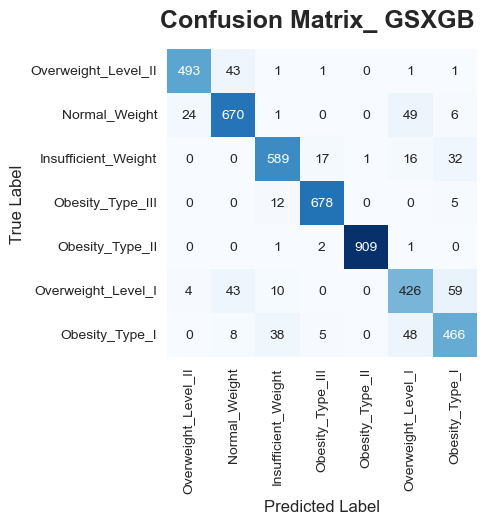

In [135]:
history_xgb, *meta_xgb = conduct_grid_search_experiment_v2(
    "GSXGB", search_space={
        'objective': ['multi:softmax'],
        'num_class': [n_targets],
        'eval_metric': ['mlogloss'],
        #
        'n_estimators': range(150, 251, 25),
        # 'n_estimators': range(205, 211, 1),
        'max_depth': range(3, 5),
        # 'max_depth': [4],
        'gamma': [0, 1],
        'learning_rate': [0.1, 0.3],
        # 'learning_rate': [0.1],
        'subsample': [0.5, 0.6, 0.7],
        # 'subsample': [0.64],
        'colsample_bytree': [.6, .7, .8],
        # 'colsample_bytree': [.77, .78],
        # 'colsample_bylevel': [.6, .7, .8],
        # 'colsample_bynode': [.6, .7, .8],
    }, model_supplier=xgb.XGBClassifier,
    environment=tree_environment)

colsample_bytree=0.6,eval_metric=mlogloss,gamma=0,learning_rate=0.1,max_depth=4,n_estimators=250,num_class=7,objective=multi:softmax,subsample=0.6


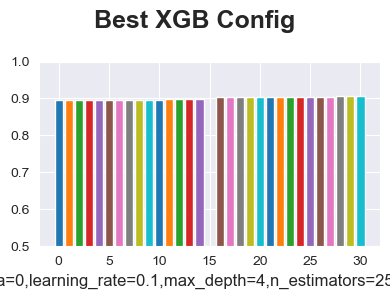

In [136]:
plot_model_comparsion("XGB", history_xgb)

### LightGBM

#### Simple CB Example

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Evaluation: LGBMClassifier

#### **Train Accuracy:** `0.9922`

#### **Val Accuracy:** `0.9028`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9891`

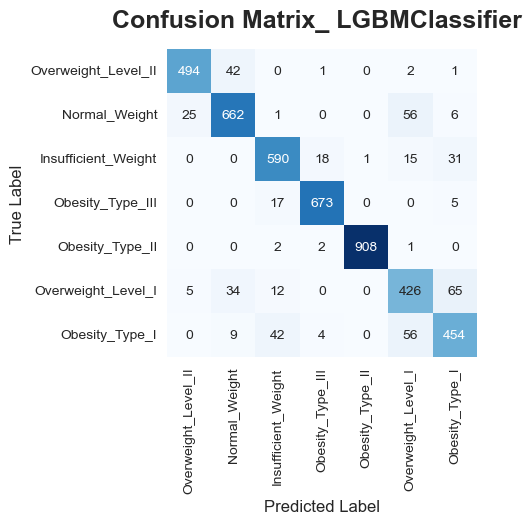

In [137]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    conduct_simple_experiment("SimpleLGBModel",
                              lgb.LGBMClassifier(verbose=0),
                              tree_environment)

#### Grid Searched LightGBM

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

### Evaluation: GSLGB

#### **Best Val Accuracy:** `0.9044428089543086`

#### **Time Elapsed:** `100.0622 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9905`

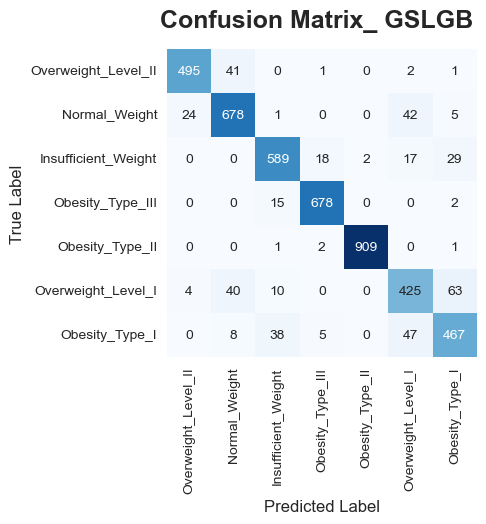

In [138]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    history_lgb, *meta_lgb = conduct_grid_search_experiment_v2(
        "GSLGB", search_space={
            'n_estimators': [100, 300],
            'max_depth': [5, 10],
            'learning_rate': [0.040, 0.045],
            'subsample': [0.9, 1.0],
            'colsample_bytree': [0.45, 0.50],
            'min_child_samples': [45],
            'reg_alpha': [0.5],
            'reg_lambda': [0.1],
            'min_child_weight': [0.005],
        }, model_supplier=lgb.LGBMClassifier,
        environment=tree_environment)

colsample_bytree=0.5,learning_rate=0.045,max_depth=5,min_child_samples=45,min_child_weight=0.005,n_estimators=300,reg_alpha=0.5,reg_lambda=0.1,subsample=1.0


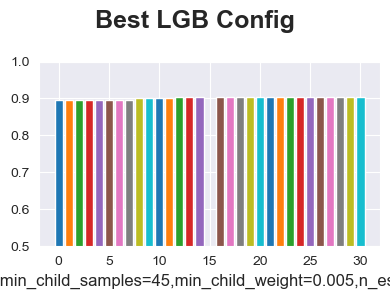

In [139]:
plot_model_comparsion("LGB", history_lgb)

**Observation**

Light GBM achieved a Best Validation Accuracy of 90.44% with n_estimators=300, and max_depth=5. It has a very comparable performance as compared to XGBoost.

### K-Nearest Neighbours

#### Data Preparation for Distance Based Models

In [140]:
distance_environment = create_environment(select_pipeline_variation(distance_pipeline, 0))

#### Simple KNN Example

### Evaluation: KNeighborsClassifier

#### **Train Accuracy:** `0.8833`

#### **Val Accuracy:** `0.8309`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9558`

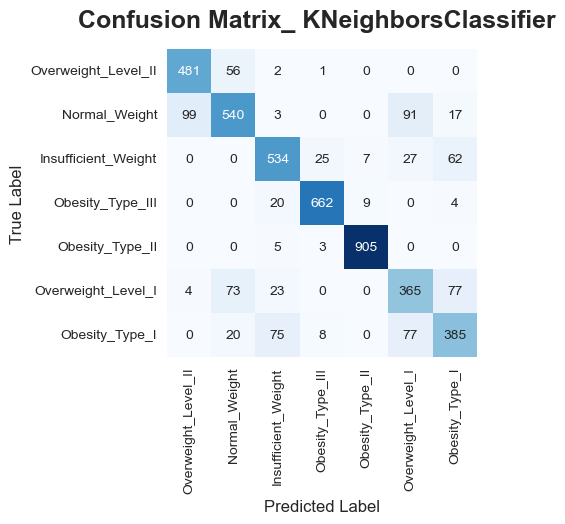

(0.8832888807136945, 0.8309012875536481)

In [141]:
conduct_simple_experiment("SimpleKNNModel", skl.neighbors.KNeighborsClassifier(), distance_environment)

#### Grid Searched K-Nearest Neighbours

Fitting 5 folds for each of 180 candidates, totalling 900 fits


### Evaluation: GSKNN

#### **Best Val Accuracy:** `0.8570776470090621`

#### **Time Elapsed:** `66.0994 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9714`

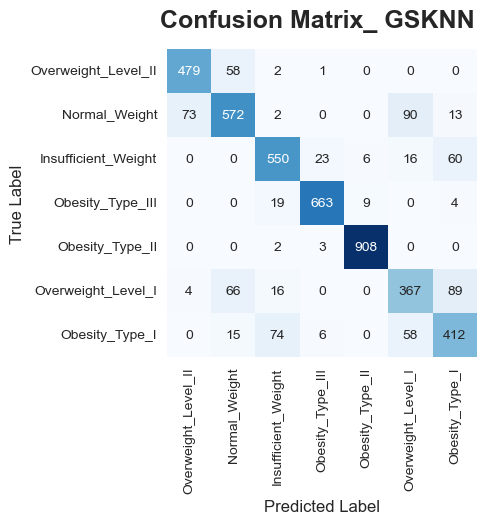

In [142]:
history_knn, *meta_knn = conduct_grid_search_experiment_v2(
    "GSKNN", search_space={
        'n_neighbors': range(5, 16, 5),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': range(80, 101, 5),
        'metric': ['euclidean', 'manhattan'],
    }, model_supplier=skl.neighbors.KNeighborsClassifier,
    environment=distance_environment)

algorithm=kd_tree,leaf_size=95,metric=manhattan,n_neighbors=10,weights=distance


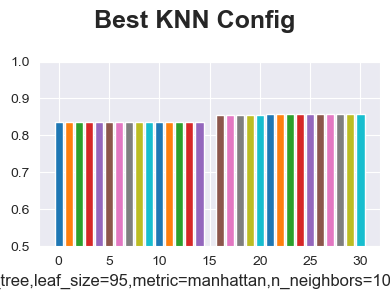

In [144]:
plot_model_comparsion("KNN", history_knn)

**Observation**

K-Nearest Neighbors (KNN) achieved a Best Validation Accuracy of 85.70% with n_neighbours=10 and distance weighting. Performance is no better than a Decision Tree or a Logistic Regression, confirming that distance-based methods struggle with overlapping class boundaries in this dataset.

### Naive Bayes

#### Data Preparation for Probability Based Models

In [145]:
probability_environment = create_environment(select_pipeline_variation(probability_pipeline_derived, 0))

#### Simple NB Example

### Evaluation: GaussianNB

#### **Train Accuracy:** `0.7415`

#### **Val Accuracy:** `0.7245`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9475`

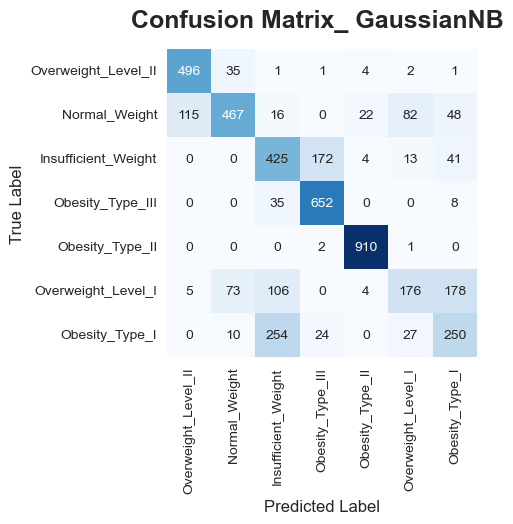

(0.7414696955761979, 0.7244635193133048)

In [146]:
conduct_simple_experiment("SimpleGNBModel", skl.naive_bayes.GaussianNB(), probability_environment)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


### Evaluation: GSGNB

#### **Best Val Accuracy:** `0.7560923346974168`

#### **Time Elapsed:** `1.2338 seconds`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9558`

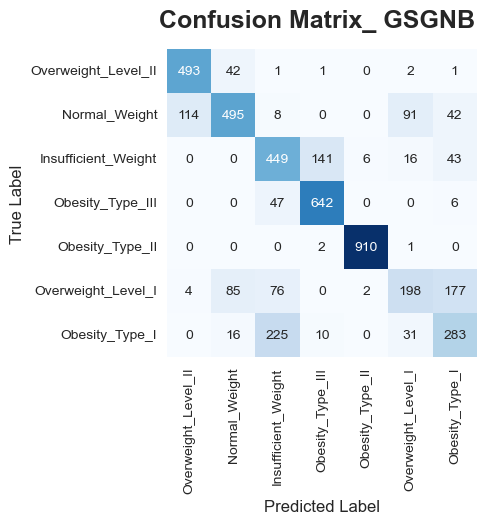

In [147]:
history_nb, *meta_nb = conduct_grid_search_experiment_v2(
    "GSGNB", search_space={
        'var_smoothing': np.logspace(-12, 12, num=25),
    }, model_supplier=skl.naive_bayes.GaussianNB,
    environment=probability_environment)

var_smoothing=0.01


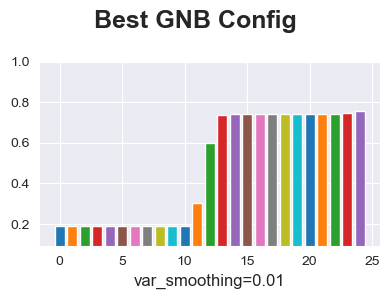

In [148]:
plot_model_comparsion("GNB", history_nb)

**Observation**

Naive Bayes achieved a Best Validation Accuracy of 75.6o%, significantly lower than other models. Despite its speed and simplicity, the independence assumption is clearly violated in this dataset, leading to underperformance. This model is unsuitable for capturing the complex, non-linear relationships present.

## Comparasion

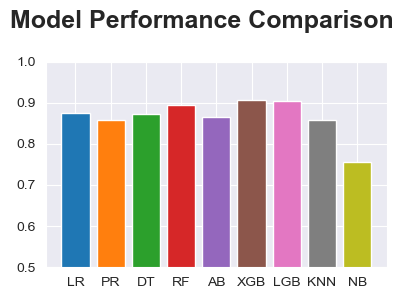

In [149]:
histories = {'lr': history_lr, 'pr': history_pr, 'dt': history_dt, 'rf': history_rf,
             'ab': history_ab, 'xgb': history_xgb, 'lgb': history_lgb, 'knn': history_knn,
             'nb': history_nb}

plt.figure(figsize=sml_fig)
for idx, (model, history) in enumerate(histories.items()):
    plt.bar(idx, np.max([x[1]['val score'] for x in history]), label=model.upper())
plt.ylim(0.5, 1)
# plt.legend()
plt.xticks(range(len(histories)), [k.upper() for k in histories.keys()])
conclude_plot("Model Performance Comparison")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


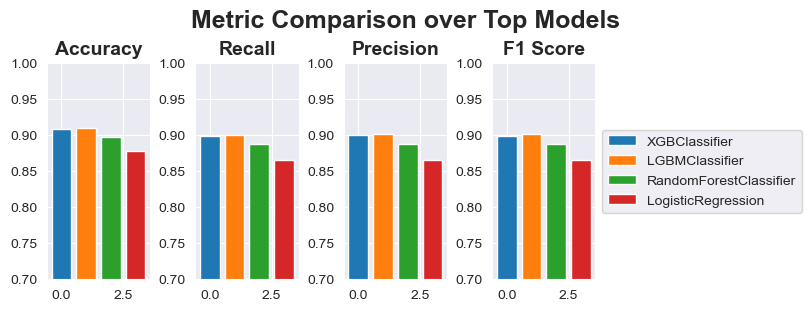

In [222]:
fig, axs = plt.subplots(1, 4, figsize=wid_fig)

for iidx, (meta, env) in enumerate(zip(
        [meta_xgb, meta_lgb, meta_rf, meta_lr],
        [tree_environment, tree_environment, tree_environment, regression_environment],
)):
    test_x, test_y = env['data_exp'][1], env['data_exp'][3]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        test_pred = meta[2].predict(test_x)
    for idx, (ax, name, score) in enumerate(zip(
            flatten(axs),
            ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
            [skl.metrics.accuracy_score, skl.metrics.recall_score, skl.metrics.precision_score, skl.metrics.f1_score],
    )):
        if 'average' in inspect.signature(score).parameters:
            value = score(test_y, test_pred, average='macro')
        else:
            value = score(test_y, test_pred)
        ax.bar(iidx, value, label=meta[2].__class__.__name__)
        ax.set_ylim(0.7, 1.0)
        annotate_plot(ax, name)
plt.legend(ncol=1, bbox_to_anchor=(1, 0.5), loc='center left')
conclude_plot("Metric Comparison over Top Models", True)

mappingproxy({'y_true': <Parameter "y_true">,
              'y_pred': <Parameter "y_pred">,
              'labels': <Parameter "labels=None">,
              'pos_label': <Parameter "pos_label=1">,
              'average': <Parameter "average='binary'">,
              'sample_weight': <Parameter "sample_weight=None">,
              'zero_division': <Parameter "zero_division='warn'">})